# Medicare opioid and non-opioid prescriber datasets cleanup and town join

### Goals:

* Clean up the Medicare Part D datasets (both the opioid prescriber and general prescription datasets)
* Merge these datasets with the town names in the opioid overdose deaths dataset

### Outputs:

Inidividual prescribers by zip code, associated with town from opioid overdose death count dataset:

Local paths:

* 2013 dataset: `data/tidy_data/medicare_partD_opioid_prescriber_2013_w_zip_MAtown_v1.csv`
* 2014 dataset: `data/tidy_data/medicare_partD_opioid_prescriber_2014_w_zip_MAtown_v1.csv`
* 2015 dataset: `data/tidy_data/medicare_partD_opioid_prescriber_2015_w_zip_MAtown_v1.csv`
* 2016 dataset: `data/tidy_data/medicare_partD_opioid_prescriber_2016_w_zip_MAtown_v1.csv`
* 2017 dataset: `data/tidy_data/medicare_partD_opioid_prescriber_2017_w_zip_MAtown_v1.csv`

Benzodiazepine prescription data years 2013-2017, with each prescriber associated with MA opioid overdose death town

* Local path: `data/tidy_data/med_partD_benzo_indiv_pres_w_town_merge_13_to_17.csv`

Summarized benzodiazepine prescription data years 2013-2017, grouped by town (from opioid overdose death dataset), year, and drug (out of the 3 benzo drugs in the dataset, by geneeric name)

* Local path: `data/tidy_data/med_partD_benzo_sum_w_town_merge_13_to_17.csv`

* pdf report (in case notebook doesn't run): products/notebook_5_medicare_opioid_and_nonopioid_prescriber_cleanup_and_town_join.pdf

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
sns.set_style('darkgrid')
sns.set(font_scale=1.5)

In [2]:
# cms opioid prescriber data
opi_pres_13_raw = pd.read_csv("../../data/raw_data/medicare_prescription_opioids/Medicare_Part_D_Opioid_Prescriber_Summary_File_2013.csv")
opi_pres_14_raw = pd.read_csv("../../data/raw_data/medicare_prescription_opioids/Medicare_Part_D_Opioid_Prescriber_Summary_File_2014.csv")
opi_pres_15_raw = pd.read_csv("../../data/raw_data/medicare_prescription_opioids/Medicare_Part_D_Opioid_Prescriber_Summary_File_2015.csv")
opi_pres_16_raw = pd.read_csv("../../data/raw_data/medicare_prescription_opioids/Medicare_Part_D_Opioid_Prescriber_Summary_File_2016.csv")
opi_pres_17_raw = pd.read_csv("../../data/raw_data/medicare_prescription_opioids/Medicare_Part_D_Opioid_Prescriber_Summary_File_2017.csv")

In [3]:
# cms non-opioid prescriber data (big file - takes a while)
all_pres_17_raw = pd.read_csv("../../data/raw_data/medicare_prescription_all_drugs/PartD_Prescriber_PUF_NPI_Drug_17.txt", sep='\t')

In [4]:
# zipcode - town association attempts
## zipcode - town lists (copy paste from websites)
zip_town_raw = pd.read_csv('../../data/raw_data/shapefiles_and_geography_related/ma_town_zipcode_list.txt', sep="(", header=None)
zip_town_raw_alt = pd.read_csv('../../data/raw_data/shapefiles_and_geography_related/ma_town_zipcode_list_alt.txt', sep='\t')
## shapfile of ma postal zipcodes
ma_postzip_map = gpd.read_file('../../data/raw_data/shapefiles_and_geography_related/zipcodes_nt/ZIPCODES_NT_POLY.shp')
# compare zipcodes and town names to the overdose deaths dataset (351 towns)
ma_over_death = pd.read_csv("../../data/tidy_data/overdose_death_count_acs_merge.csv")

In [5]:
# easier column names for opi prescriber dfs
lwr_column_names =[x.lower().replace(' ', '_') for x in opi_pres_13_raw.columns]
raw_opi_dflist = [opi_pres_13_raw, opi_pres_14_raw, opi_pres_15_raw, opi_pres_16_raw, opi_pres_17_raw]
for x in raw_opi_dflist:
    x.columns = lwr_column_names

In [6]:
# number of rows in each file:
for x in raw_opi_dflist:
    print(x.shape)

(1049299, 11)
(1072978, 11)
(1102253, 11)
(1131550, 11)
(1162898, 11)


In [7]:
# what the columns look like:
opi_pres_17_raw.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate
0,1003000126,ENKESHAFI,ARDALAN,21502.0,MD,Internal Medicine,677,25.0,3.69,NaN,NaN
1,1003000142,KHALIL,RASHID,43623.0,OH,Anesthesiology,1946,1040.0,53.44,200.0,19.23
2,1003000167,ESCOBAR,JULIO,89403.0,NV,Dentist,55,14.0,25.45,0.0,0.00
3,1003000175,REYES-VASQUEZ,BELINDA,91744.0,CA,Dentist,18,0.0,0.00,0.0,NaN
4,1003000282,BLAKEMORE,ROSIE,37243.0,TN,Nurse Practitioner,90,0.0,0.00,0.0,NaN


In [8]:
all_pres_17_raw.columns

Index(['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name',
       'nppes_provider_city', 'nppes_provider_state', 'specialty_description',
       'description_flag', 'drug_name', 'generic_name', 'bene_count',
       'total_claim_count', 'total_30_day_fill_count', 'total_day_supply',
       'total_drug_cost', 'bene_count_ge65', 'bene_count_ge65_suppress_flag',
       'total_claim_count_ge65', 'ge65_suppress_flag',
       'total_30_day_fill_count_ge65', 'total_day_supply_ge65',
       'total_drug_cost_ge65'],
      dtype='object')

The opioid prescriber dataset comes with a zip code, but the dataset for all drug comes only with a town name.

Questions to address:

* do the NPI's (unique provider IDs - I think) match between the 2 prescriber datasets?
* do the town names in the all-drugs prescriber dataset match the town names in the opioid overdose data? 

Potential merge options: 
* merge 1: opioid overdose death counts + all-drug prescribers on town -> merge 2: merge to opioid prescribers by npi
* merge 1: opioid prescribers to town (using postal map) to associate zipcodes with town -> merge 2: merge to opioid overdose deaths -> use merge 1 to associate all-drug prescribers with opioid overdose death town based on npi

In [9]:
opi_pres_17_MA = opi_pres_17_raw[opi_pres_17_raw['nppes_provider_state'] == 'MA'].copy()
all_pres_17_MA = all_pres_17_raw[all_pres_17_raw['nppes_provider_state'] == 'MA'].copy()
# all-drug prescriber dataset is very large, focus on the prescribers/providers only for now
all_pres_17_MA_prov = all_pres_17_MA.iloc[:, 0:6].copy().drop_duplicates()

In [10]:
display(opi_pres_17_MA.head())
display(all_pres_17_MA_prov.head())

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate
36,1003002312,HOPKINS,PATRICIA,2169.0,MA,Rheumatology,4487,513.0,11.43,84.0,16.37
118,1003007477,ABDOW,KIMBERLY,1609.0,MA,Nurse Practitioner,5314,0.0,0.00,0.0,NaN
132,1003008244,RAJBHANDARI,RUMA,2115.0,MA,Gastroenterology,56,0.0,0.00,0.0,NaN
189,1003011610,RAY,ALAKA,2114.0,MA,Internal Medicine,1993,62.0,3.11,NaN,NaN
224,1003012766,KANO,ZACHARY,2445.0,MA,Dentist,19,0.0,0.00,0.0,NaN


,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description
757,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology
2478,1003007477,ABDOW,KIMBERLY,WORCESTER,MA,Nurse Practitioner
2997,1003008244,RAJBHANDARI,RUMA,BOSTON,MA,Gastroenterology
4569,1003011610,RAY,ALAKA,BOSTON,MA,Internal Medicine
5158,1003012766,KANO,ZACHARY,BROOKLINE,MA,Dentist


In [11]:
# NPI sanity check
print(len(set(opi_pres_17_MA['npi']) - set(all_pres_17_MA['npi'])))
print(len(set(all_pres_17_MA['npi']) - set(opi_pres_17_MA['npi'])))
print(len(set(opi_pres_17_MA['npi']) - set(all_pres_17_raw['npi'])))
print(len(set(all_pres_17_MA['npi'])))
print(len(set(opi_pres_17_MA['npi'])))

8430
0
8430
27300
35730


Interesting - 
There are 8,430 more unique prescribers in the opioid prescription dataset than in the all-drugs prescriber dataset

Not sure why that would be the case.

Maybe a difference in specialties?

In [12]:
print(opi_pres_17_MA.shape)
print(all_pres_17_MA_prov.shape)
opi_pres_MA_miss = opi_pres_17_MA[~ opi_pres_17_MA['npi'].isin(set(all_pres_17_MA['npi']))].copy()
display(opi_pres_MA_miss['specialty_description'].value_counts())
display(all_pres_17_MA['specialty_description'].value_counts())

(35730, 11)
(27300, 6)


Internal Medicine                                                 1355
Nurse Practitioner                                                1011
Dentist                                                            890
Student in an Organized Health Care Education/Training Program     890
Physician Assistant                                                550
                                                                  ... 
Sleep Medicine                                                       1
Assistant, Podiatric                                                 1
Physical Therapist in Private Practice                               1
Community/Behavioral Health                                          1
Social Worker                                                        1
Name: specialty_description, Length: 97, dtype: int64

Internal Medicine                                     242242
Nurse Practitioner                                     85862
Family Practice                                        83128
Psychiatry                                             26665
Physician Assistant                                    26472
                                                       ...  
Hospital                                                   1
Assistant, Podiatric                                       1
Registered Dietitian or Nutrition Professional             1
Thoracic Surgery (Cardiothoracic Vascular Surgery)         1
Midwife                                                    1
Name: specialty_description, Length: 96, dtype: int64

Top specialties for opioid prescribers missing from the all-drugs prescriber dataset are Internal Medicine and Nurse Practitioner, but those are also present in the all-drugs prescriber dataset. Maybe specialty is not the reason for difference? 

The difference may be in how Medicare created these datasets - maybe different benefit plans? I tried to read the methodology on the website, but it wasn't clear to me. 

Moving on

Q: are the towns in the all-drugs prescriber database a match for the names in the opioid overdose death count dataset?

In [13]:
# number of towns in the opioid overdose death data missing in the all-drug prescriber dataset:
print(len(set(ma_over_death['city_death']) - set(all_pres_17_MA_prov['nppes_provider_city'].str.lower())))
# number of towns in the all-drugs prescriber dataset missing from the opioid overdose death dataset
print(len(set(all_pres_17_MA_prov['nppes_provider_city'].str.lower()) - set(ma_over_death['city_death'])))

85
194


Expected that this would be an issue - the towns don't match well - likely different definitions of town/cities

Have to go with this strategy:

merge 1: opioid prescribers to town (using postal map) to associate zipcodes with town -> merge 2: merge to opioid overdose deaths -> use merge 1 to associate all-drug prescribers with opioid overdose death town based on npi

### Step 1: try to associate zip codes in the opioid prescriber dataset with town in the opioid overdose death count dataset

But first, zip codes were imported as floats and missing leading zero that is typicaly seen in a zip code - fix this

In [14]:
opi_pres_17_MA['nppes_provider_zip_code'] = [x.zfill(5) for x in list(opi_pres_17_MA['nppes_provider_zip_code'].astype(int).astype(str))]
opi_pres_17_MA.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate
36,1003002312,HOPKINS,PATRICIA,02169,MA,Rheumatology,4487,513.0,11.43,84.0,16.37
118,1003007477,ABDOW,KIMBERLY,01609,MA,Nurse Practitioner,5314,0.0,0.00,0.0,NaN
132,1003008244,RAJBHANDARI,RUMA,02115,MA,Gastroenterology,56,0.0,0.00,0.0,NaN
189,1003011610,RAY,ALAKA,02114,MA,Internal Medicine,1993,62.0,3.11,NaN,NaN
224,1003012766,KANO,ZACHARY,02445,MA,Dentist,19,0.0,0.00,0.0,NaN


2 zip code - town association lists copied from websites - will either work?

In [15]:
print(zip_town_raw.shape)
print(zip_town_raw_alt.shape)
print(zip_town_raw.columns)
print(zip_town_raw_alt.columns)

(1093, 2)
(682, 4)
Int64Index([0, 1], dtype='int64')
Index(['ZIP Code ', 'City ', 'County ', 'Type'], dtype='object')


In [16]:
display(zip_town_raw.head())
display(zip_town_raw_alt.head())

,0,1
0,02351 Abington,781)
1,02018 Accord,781)
2,01718 Acton,978)
3,01719 Acton,978)
4,01720 Acton,978)


,ZIP Code,City,County,Type
0,ZIP Code 01001,Agawam,Hampden,Standard
1,ZIP Code 01002,Amherst,Hampshire,Standard
2,ZIP Code 01003,Amherst,Hampshire,Standard
3,ZIP Code 01004,Amherst,Hampshire,P.O. Box
4,ZIP Code 01005,Barre,Worcester,Standard


Both potentially need cleaning, if they're useful

In [17]:
# pull out zip code to separate column
zip_town = zip_town_raw.iloc[:, [0]].copy()
zip_town.columns = ['col1']
zip_town['zip'] = [x[:5] for x in zip_town['col1']]
zip_town.head()

,col1,zip
0,02351 Abington,02351
1,02018 Accord,02018
2,01718 Acton,01718
3,01719 Acton,01719
4,01720 Acton,01720


In [18]:
# now pull out town name
zip_town['town'] = [x[6:] for x in zip_town['col1']]
# towns have white spaces at the end (carryover from formatting)
zip_town['town'] = zip_town['town'].str.strip().str.lower()
zip_town.drop('col1', axis=1, inplace=True)
zip_town.head()

,zip,town
0,02351,abington
1,02018,accord
2,01718,acton
3,01719,acton
4,01720,acton


In [19]:
ma_over_death.head()

,city_death,2014,2015,2016,2017,2018,tot_pop_13,tot_pop_14,tot_pop_15,tot_pop_16,tot_pop_17,over_65_count,over_65_prop,med_house_inc,mean_house_inc,less_than_hs_ed,at_or_below_pov_prop,pop_struggling_prop,urb_v_rur,town_status
0,abington,0,6,1,3,5,16109.285714,16150.714286,16192.142857,16233.571429,16275,2469,0.151705,87156.000000,98809.035505,5.405643,0.035754,0.100408,rural,grown
1,acton,1,2,3,0,1,22580.142857,22798.857143,23017.571429,23236.285714,23455,4001,0.170582,139890.466667,156680.203867,2.456531,0.038315,0.041747,rural,grown
2,acushnet,0,4,2,4,0,10363.000000,10383.000000,10403.000000,10423.000000,10443,2431,0.232788,69624.714286,80333.175842,18.297315,0.040828,0.178406,rural,grown
3,adams,2,3,1,0,4,8367.571429,8328.428571,8289.285714,8250.142857,8211,1764,0.214834,48445.400000,60968.594660,11.862182,0.110854,0.144597,rural,shrunk
4,agawam,1,2,0,4,8,27684.428571,27705.571429,27726.714286,27747.857143,27769,6195,0.223090,65490.125000,79464.234446,7.748863,0.094819,0.142656,rural,grown


In [20]:
print(len(set(zip_town['town'])))
print(len(set(ma_over_death['city_death'])))

806
347


In [21]:
np.unique(zip_town['town'])[:20]

array(['abington', 'accord', 'acton', 'acushnet', 'adams',
       'aetna life & casualty co', 'agawam', 'alford', 'allendale',
       'allmerica', 'allston', 'amesbury', 'amherst', 'andover',
       'aquinnah', 'arlington', 'arlington heights', 'ashburnham',
       'ashby', 'ashfield'], dtype=object)

Town names are too granular, try the other one

In [22]:
zip_town_raw_alt.columns = [x.lower().strip() for x in list(zip_town_raw_alt.columns)]

In [23]:
len(np.unique(zip_town_raw_alt['city']))
# still too many towns

512

In [24]:
# what are the zip code types?
zip_town_raw_alt['type'].value_counts()

Standard    492
P.O. Box    156
Unique       34
Name: type, dtype: int64

In [25]:
# try filtering down - maybe that will help?
zip_stand = zip_town_raw_alt[zip_town_raw_alt['type'] == 'Standard'].copy()
print(len(set(zip_stand['city'])))
# closer count - try matching what's missing
zip_stand['city'] = zip_stand['city'].str.lower()
zip_stand.head()

417


,zip code,city,county,type
0,ZIP Code 01001,agawam,Hampden,Standard
1,ZIP Code 01002,amherst,Hampshire,Standard
2,ZIP Code 01003,amherst,Hampshire,Standard
4,ZIP Code 01005,barre,Worcester,Standard
5,ZIP Code 01007,belchertown,Hampshire,Standard


In [26]:
# mismatches
print(len(set(ma_over_death['city_death']) - set(zip_stand['city'])))
print(len(set(zip_stand['city']) - set(ma_over_death['city_death'])))
# still a lot of mismatches - maybe there's a better source?

39
109


In [27]:
ma_postzip_map.head()

,POSTCODE,PC_NAME,PC_TYPE,PA_NAME,PA_FIPS,CITY_TOWN,COUNTY,AREA_SQMI,SHAPE_AREA,SHAPE_LEN,geometry
0,01331,ATHOL,NON UNIQUE,ATHOL,02515,"ATHOL, TOWN OF",WORCESTER,58.084870,1.504391e+08,66459.581259,"POLYGON ((147583.6014999971 930766.1334999986,..."
1,01085,WESTFIELD,NON UNIQUE,WESTFIELD,76030,WESTFIELD,HAMPDEN,55.938928,1.448812e+08,61329.577100,"POLYGON ((101952.2437999994 882113.238499999, ..."
2,01370,SHELBURNE FALLS,NON UNIQUE,SHELBURNE FALLS,61205,"SHELBURNE, TOWN OF",FRANKLIN,48.804057,1.264019e+08,70885.011312,"POLYGON ((107090.9670000002 933358.561999999, ..."
3,01235,HINSDALE,NON UNIQUE,HINSDALE,30280,"HINSDALE, TOWN OF",BERKSHIRE,47.757052,1.236902e+08,49286.404925,"POLYGON ((77728.64249999821 914027.9114000015,..."
4,02747,NORTH DARTMOUTH,NON UNIQUE,NORTH DARTMOUTH,47450,"DARTMOUTH, TOWN OF",BRISTOL,47.495414,1.230126e+08,66614.835420,"POLYGON ((242894.990199998 830521.8995000012, ..."


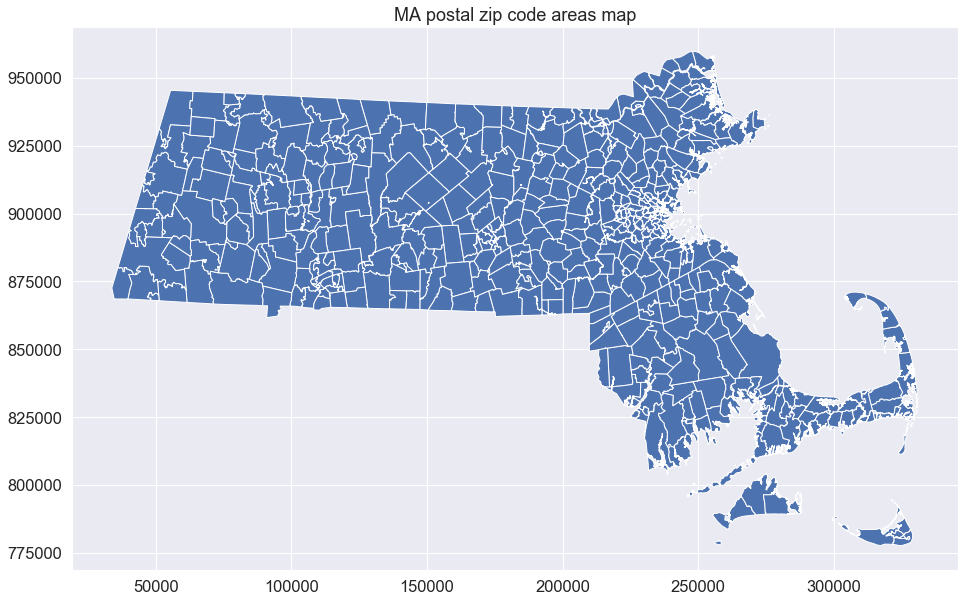

In [28]:
ma_postzip_map.plot(figsize=(16,10))
plt.title('MA postal zip code areas map')
plt.show()

In [29]:
print(len(set(ma_postzip_map['CITY_TOWN'])))
print(len(set(ma_postzip_map['PC_NAME'])))

335
458


In [30]:
# fix the city_town column - this looks to be what I might be looking for
ma_postzip_map['CITY_TOWN'] = ma_postzip_map['CITY_TOWN'].str.lower().str.replace(', town of', '')

In [31]:
# mismatches - what's in the postal map that's not in the opioid overdose dataset?:
set(ma_postzip_map['CITY_TOWN']) - set(ma_over_death['city_death'])

{'charlemont',
 'manchester by the sea',
 'monroe',
 'mt washington',
 'worthington'}

In [32]:
# what's in the opioid overdose dataset that's not in the postal map?
set(ma_over_death['city_death']) - set(ma_postzip_map['CITY_TOWN'])

{'alford',
 'aquinnah',
 'clarksburg',
 'granville',
 'hawley',
 'leyden',
 'manchester',
 'montgomery',
 'mount washington',
 'new ashford',
 'pelham',
 'peru',
 'phillipston',
 'tisbury',
 'washington',
 'west tisbury',
 'westhampton'}

Much more manageable, few fixes

* manchester and manchester by the sea seem to be the same town (wikipedia)
* mt washington and mount washington - different spelling
* charlemont was one of the towns without a census block association (notebook 3)

In [33]:
ma_over_death['city_death_match'] = ma_over_death['city_death'].str.replace('manchester', 'manchester by the sea').str.replace('mount washington', 'mt washington')

In [34]:
# death counts for towns/cities I'm missing
ma_over_death[ma_over_death['city_death_match'].isin(set(ma_over_death['city_death_match']) - set(ma_postzip_map['CITY_TOWN'].str.lower().str.replace(', town of', '')))]

,city_death,2014,2015,2016,2017,2018,tot_pop_13,tot_pop_14,tot_pop_15,tot_pop_16,...,over_65_count,over_65_prop,med_house_inc,mean_house_inc,less_than_hs_ed,at_or_below_pov_prop,pop_struggling_prop,urb_v_rur,town_status,city_death_match
5,alford,0,0,0,0,0,458.428571,446.571429,434.714286,422.857143,...,219,0.532847,105625.00,148519.270833,1.453488,0.048662,0.024331,rural,shrunk,alford
9,aquinnah,0,0,0,0,0,452.000000,499.000000,546.000000,593.000000,...,66,0.103125,80250.00,103304.316547,9.667674,0.217188,0.050000,rural,grown,aquinnah
62,clarksburg,0,0,0,1,0,1710.571429,1713.428571,1716.285714,1719.142857,...,494,0.286876,60558.00,72516.151094,7.096774,0.095404,0.132635,rural,uncertain,clarksburg
109,granville,0,0,0,0,0,1606.285714,1619.714286,1633.142857,1646.571429,...,302,0.181928,86000.00,93351.480263,4.056291,0.083942,0.065693,rural,grown,granville
126,hawley,0,0,0,0,0,930.857143,942.142857,953.428571,964.714286,...,267,0.273566,59167.00,71880.150754,9.433962,0.118191,0.157246,rural,grown,hawley
153,leyden,0,0,0,0,0,1809.571429,1805.428571,1801.285714,1797.142857,...,443,0.247072,65588.00,81706.330749,5.201465,0.114607,0.112921,rural,uncertain,leyden
190,montgomery,0,0,0,0,0,822.571429,817.428571,812.285714,807.142857,...,148,0.184539,74000.00,91171.739130,3.398058,0.037406,0.087282,rural,uncertain,montgomery
196,new ashford,0,0,0,0,0,273.428571,288.571429,303.714286,318.857143,...,81,0.242515,84583.00,92367.213115,7.053942,0.078788,0.042424,rural,grown,new ashford
226,pelham,0,0,0,0,0,1302.142857,1295.857143,1289.571429,1283.285714,...,343,0.268598,92250.00,116789.122137,2.277433,0.040031,0.032967,rural,uncertain,pelham
229,peru,0,0,0,1,0,831.571429,826.428571,821.285714,816.142857,...,115,0.141800,68636.00,77355.714286,8.307210,0.067818,0.108508,rural,uncertain,peru


These are pretty small towns - for some, it looks like they're considered to be a part of other towns? 

Have to keep moving on, afraid will have to lose them

In [35]:
# how many zipcodes in prescriber dataset not in the postal map?
print(len(set(opi_pres_17_MA['nppes_provider_zip_code']) - set(ma_postzip_map['POSTCODE'])))
# other way around?
print(len(set(ma_postzip_map['POSTCODE']) - set(opi_pres_17_MA['nppes_provider_zip_code'])))

74
105


In [36]:
# try to fix mismatches - how many prescribers are associated with zip codes not in the postal map shapefile?
zip_miss = set(opi_pres_17_MA['nppes_provider_zip_code']) - set(ma_postzip_map['POSTCODE'])
# total number of unique npi in 2017 MA opioid prescriber dataset:
print(len(set(opi_pres_17_MA['npi'])))
# number missing from the postal zip codes map
print(len(set(opi_pres_17_MA[opi_pres_17_MA['nppes_provider_zip_code'].isin(zip_miss)]['npi'])))

35730
2316


In [37]:
opi_pres_17_MA[opi_pres_17_MA['nppes_provider_zip_code'].isin(zip_miss)]

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate
303,1003015686,BLUME,DEBORAH,01199,MA,Physician Assistant,1562,28.0,1.79,0.0,0.0
769,1003041971,IRONS,HILLARY,01655,MA,Emergency Medicine,53,NaN,NaN,0.0,NaN
1516,1003080151,NICORA,AGNIESZKA,01199,MA,Emergency Medicine,216,NaN,NaN,0.0,NaN
1662,1003090143,DUBIN,JOSEPH,01805,MA,Internal Medicine,139,NaN,NaN,0.0,NaN
1995,1003108259,KORAPATI,SOWMYA,01655,MA,Hematology-Oncology,15,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1159959,1992854707,ABRAMOV,KONSTANTIN,01655,MA,Nephrology,1519,27.0,1.78,NaN,NaN
1160834,1992891352,DEPETERS,FRANKLIN,01655,MA,Diagnostic Radiology,68,0.0,0.00,0.0,NaN
1161153,1992902977,CROWLEY,JILLIAN,01199,MA,Physician Assistant,107,18.0,16.82,0.0,0.0
1162263,1992964183,MACLACHLAN,LARA,01805,MA,Urology,1487,NaN,NaN,0.0,NaN


In [38]:
# subset map to try and match up zip codes and towns
postzip_town_match = ma_postzip_map.iloc[:, 0:7]
display(postzip_town_match.head())

,POSTCODE,PC_NAME,PC_TYPE,PA_NAME,PA_FIPS,CITY_TOWN,COUNTY
0,01331,ATHOL,NON UNIQUE,ATHOL,02515,athol,WORCESTER
1,01085,WESTFIELD,NON UNIQUE,WESTFIELD,76030,westfield,HAMPDEN
2,01370,SHELBURNE FALLS,NON UNIQUE,SHELBURNE FALLS,61205,shelburne,FRANKLIN
3,01235,HINSDALE,NON UNIQUE,HINSDALE,30280,hinsdale,BERKSHIRE
4,02747,NORTH DARTMOUTH,NON UNIQUE,NORTH DARTMOUTH,47450,dartmouth,BRISTOL


In [39]:
# PC and PA name columns look identical - are they?
print(sum(postzip_town_match['PC_NAME'] != postzip_town_match['PA_NAME']))
display(postzip_town_match[postzip_town_match['PC_NAME'] != postzip_town_match['PA_NAME']])
postzip_town_match = postzip_town_match.apply(lambda x: x.str.lower())
postzip_town_match.head()

3


,POSTCODE,PC_NAME,PC_TYPE,PA_NAME,PA_FIPS,CITY_TOWN,COUNTY
497,01441,TYCO,UNIQUE ORGANIZATION,WESTMINSTER,76975,westminster,WORCESTER
520,02357,STONEHILL COLLEGE,UNIQUE ORGANIZATION,NORTH EASTON,47625,easton,BRISTOL
530,01063,SMITH COLLEGE,UNIQUE ORGANIZATION,NORTHAMPTON,46330,northampton,HAMPSHIRE


,POSTCODE,PC_NAME,PC_TYPE,PA_NAME,PA_FIPS,CITY_TOWN,COUNTY
0,01331,athol,non unique,athol,02515,athol,worcester
1,01085,westfield,non unique,westfield,76030,westfield,hampden
2,01370,shelburne falls,non unique,shelburne falls,61205,shelburne,franklin
3,01235,hinsdale,non unique,hinsdale,30280,hinsdale,berkshire
4,02747,north dartmouth,non unique,north dartmouth,47450,dartmouth,bristol


In [40]:
print(set(ma_over_death['city_death_match']) - set(postzip_town_match['CITY_TOWN']))
print(set(postzip_town_match['CITY_TOWN']) - set(ma_over_death['city_death_match']))

{'clarksburg', 'aquinnah', 'new ashford', 'tisbury', 'peru', 'phillipston', 'alford', 'west tisbury', 'westhampton', 'granville', 'pelham', 'hawley', 'washington', 'montgomery', 'leyden'}
{'charlemont', 'worthington', 'monroe'}


In [41]:
len(zip_miss)

74

Maybe the zip code - town association files will be useful for filling in these missing town - zip code associations that do match the opioid overdose death dataset?

In [42]:
print(len(set(ma_over_death['city_death_match']) - set(zip_town['town'])))
print(len(set(ma_over_death['city_death_match']) - set(zip_town_raw_alt['city'].str.lower())))
#zip_town town names are more similar to the opioid overdose death count towns - try that one

4
28


In [43]:
print(len(zip_miss))
print(len(zip_town[zip_town['zip'].isin(zip_miss)]))

74
36


In [44]:
zip_fill = zip_town[zip_town['zip'].isin(zip_miss) & zip_town['town'].isin(set(ma_over_death['city_death']))]
zip_fill

,zip,town
88,02117,boston
111,02199,boston
118,02211,boston
124,02241,boston
143,02185,braintree
148,02325,bridgewater
167,01805,burlington
177,02238,cambridge
298,02334,easton
309,02722,fall river


In [45]:
zip_town_fin = postzip_town_match[['POSTCODE', 'CITY_TOWN']]
zip_town_fin.columns = list(zip_fill.columns)
zip_town_fin = pd.concat([zip_town_fin, zip_fill]).reindex()
print(zip_town_fin.shape)
print(zip_town_fin.drop_duplicates().shape)
zip_town_fin.head()

(572, 2)
(572, 2)


,zip,town
0,01331,athol
1,01085,westfield
2,01370,shelburne
3,01235,hinsdale
4,02747,dartmouth


In [46]:
print(len(set(zip_town_fin['town']) - set(ma_over_death['city_death_match'])))
print(len(set(ma_over_death['city_death_match']) - set(zip_town_fin['town'])))
print(set(zip_town_fin['town']) - set(ma_over_death['city_death_match']))
print(set(ma_over_death['city_death_match']) - set(zip_town_fin['town']))
# getting closer

3
13
{'charlemont', 'worthington', 'monroe'}
{'clarksburg', 'aquinnah', 'new ashford', 'peru', 'phillipston', 'alford', 'westhampton', 'granville', 'pelham', 'hawley', 'washington', 'montgomery', 'leyden'}


In [47]:
# zip codes that have a town association - but that town name is not in the opioid overdose death data 
# do these zip codes have another association that matches the opioid overdose death data?
zip_miss_town = zip_town[zip_town['zip'].isin(zip_miss) & ~zip_town['town'].isin(set(ma_over_death['city_death']))].copy()
display(zip_miss_town)
# used manual database look up to look these up
zip_miss_town['alt_town'] = ['springfield', 'bridgewater', 'orleans',
                   'boston', 'cambridge', 'danvers',
                   'burlington', 'plymouth', 'marshfield',
                   'eastham', 'northampton', 'winchendon', 'winchendon']
zip_miss_town

,zip,town
54,01199,baystate medical
149,02325,bridgewater state college
282,02643,east orleans
323,02241,fleet bank boston
383,02238,harvard square
391,01937,hathorne
445,01805,lahey clinic medical center
498,02345,manomet
509,02051,marshfield hills
651,02651,north eastham


,zip,town,alt_town
54,01199,baystate medical,springfield
149,02325,bridgewater state college,bridgewater
282,02643,east orleans,orleans
323,02241,fleet bank boston,boston
383,02238,harvard square,cambridge
391,01937,hathorne,danvers
445,01805,lahey clinic medical center,burlington
498,02345,manomet,plymouth
509,02051,marshfield hills,marshfield
651,02651,north eastham,eastham


In [48]:
# are all of these new alternative town names in the opioid overdose death dataset?
set(zip_miss_town['alt_town']) - set(ma_over_death['city_death_match'])
# yes

set()

In [49]:
display(zip_town_fin)
# modify to combine these two dfs
zip_miss_town = zip_miss_town.drop('town', axis=1)
zip_miss_town.columns = zip_town_fin.columns

,zip,town
0,01331,athol
1,01085,westfield
2,01370,shelburne
3,01235,hinsdale
4,02747,dartmouth
...,...,...
892,01199,springfield
923,02575,tisbury
1015,02575,west tisbury
1082,01614,worcester


In [50]:
zip_town_fin = pd.concat([zip_town_fin, zip_miss_town]).drop_duplicates()
print(zip_town_fin.shape)
zip_town_fin.head()

(578, 2)


,zip,town
0,01331,athol
1,01085,westfield
2,01370,shelburne
3,01235,hinsdale
4,02747,dartmouth


In [51]:
print(len(set(zip_town_fin['town']) - set(ma_over_death['city_death_match'])))
print(len(set(ma_over_death['city_death_match']) - set(zip_town_fin['town'])))
print(set(zip_town_fin['town']) - set(ma_over_death['city_death_match']))
print(set(ma_over_death['city_death_match']) - set(zip_town_fin['town']))

3
13
{'charlemont', 'worthington', 'monroe'}
{'clarksburg', 'aquinnah', 'new ashford', 'peru', 'phillipston', 'alford', 'westhampton', 'granville', 'pelham', 'hawley', 'washington', 'montgomery', 'leyden'}


In [52]:
# how many zip codes associated with more than 1 town?
zip_town_counts = zip_town_fin['zip'].value_counts().reset_index()
zip_town_counts.columns = ['zip', 'count']
print(zip_town_counts[zip_town_counts['count'] > 1].shape)
zip_town_counts[zip_town_counts['count'] > 1]

(23, 2)


,zip,count
0,02467,3
1,01082,3
2,02148,2
3,01010,2
4,02135,2
5,01096,2
6,01070,2
7,02151,2
8,01434,2
9,01235,2


In [53]:
# number of opi prescribers now missing with this better zip code - town association list:
print(opi_pres_17_MA[opi_pres_17_MA['nppes_provider_zip_code'].isin(set(opi_pres_17_MA['nppes_provider_zip_code']) - set(zip_town_fin['zip']))].shape)
# down from 2k + missing to only 52 - great!

(52, 11)


### Step 2: Associate all opioid prescribers with opioid overdose death town name (join by zip code) and 2017 all-drug prescribers with zip code (based on npi from opioid prescriber dataset) and then with town (based on zip code)

* how many all-drug prescribers don't have an associated town?
* check for duplicate town assignments to prescribers

In [54]:
# give the all drug prescribers zipcodes
all_pres_17_MA_prov = all_pres_17_MA_prov.merge(opi_pres_17_MA[['npi', 'nppes_provider_zip_code']], on='npi', how='left')
display(all_pres_17_MA_prov.info())
display(all_pres_17_MA_prov.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27300 entries, 0 to 27299
Data columns (total 7 columns):
npi                             27300 non-null int64
nppes_provider_last_org_name    27299 non-null object
nppes_provider_first_name       27300 non-null object
nppes_provider_city             27300 non-null object
nppes_provider_state            27300 non-null object
specialty_description           27300 non-null object
nppes_provider_zip_code         27300 non-null object
dtypes: int64(1), object(6)
memory usage: 1.7+ MB


None

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,nppes_provider_zip_code
0,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,02169
1,1003007477,ABDOW,KIMBERLY,WORCESTER,MA,Nurse Practitioner,01609
2,1003008244,RAJBHANDARI,RUMA,BOSTON,MA,Gastroenterology,02115
3,1003011610,RAY,ALAKA,BOSTON,MA,Internal Medicine,02114
4,1003012766,KANO,ZACHARY,BROOKLINE,MA,Dentist,02445


In [55]:
# number of all drug prescribers missing/being dropped because of zip code:
print(len(set(all_pres_17_MA_prov['npi'])))
print(all_pres_17_MA_prov[all_pres_17_MA_prov['nppes_provider_zip_code'].isin(set(all_pres_17_MA_prov['nppes_provider_zip_code']) - set(zip_town_fin['zip']))].shape)
# only 41 - great

27300
(41, 7)


In [56]:
opi_pres_17_MA['nppes_provider_last_name'] = opi_pres_17_MA['nppes_provider_last_name'].str.lower()
opi_pres_17_MA['nppes_provider_first_name'] = opi_pres_17_MA['nppes_provider_first_name'].str.lower()
opi_pres_17_MA['specialty_description'] = opi_pres_17_MA['specialty_description'].str.lower()
print(opi_pres_17_MA.shape)
opi_pres_17_town = opi_pres_17_MA.merge(zip_town_fin, how='inner', left_on='nppes_provider_zip_code', right_on='zip')
print(opi_pres_17_town.shape)
opi_pres_17_town.head()

(35730, 11)
(37069, 13)


,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate,zip,town
0,1003002312,hopkins,patricia,02169,MA,rheumatology,4487,513.0,11.43,84.0,16.37,02169,quincy
1,1003083270,kabadi,mitesh,02169,MA,cardiology,1363,0.0,0.00,0.0,NaN,02169,quincy
2,1003291121,blair,meghan,02169,MA,nurse practitioner,905,0.0,0.00,0.0,NaN,02169,quincy
3,1003834433,nair,anil,02169,MA,neurology,1133,NaN,NaN,NaN,NaN,02169,quincy
4,1003992397,carolan,patricia,02169,MA,dentist,54,NaN,NaN,0.0,NaN,02169,quincy


In [57]:
# number of opi prescribers w/more than 1 town association:
print(opi_pres_17_MA[opi_pres_17_MA['nppes_provider_zip_code'].isin(set(zip_town_counts[zip_town_counts['count'] > 1]['zip']))].shape)
# number of all drug prescribers w/more than 1 town association:
print(all_pres_17_MA_prov[all_pres_17_MA_prov['nppes_provider_zip_code'].isin(set(zip_town_counts[zip_town_counts['count'] > 1]['zip']))].shape)

(1156, 11)
(876, 7)


In [58]:
opi_pres_17_cols = list(opi_pres_17_town.columns)
# reoder columns and drop extra zipcode col that appeared because of merge
opi_pres_17_town = opi_pres_17_town[opi_pres_17_cols[0:4] + opi_pres_17_cols[-1:] + opi_pres_17_cols[4:10]]
opi_pres_17_town.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count
0,1003002312,hopkins,patricia,02169,quincy,MA,rheumatology,4487,513.0,11.43,84.0
1,1003083270,kabadi,mitesh,02169,quincy,MA,cardiology,1363,0.0,0.00,0.0
2,1003291121,blair,meghan,02169,quincy,MA,nurse practitioner,905,0.0,0.00,0.0
3,1003834433,nair,anil,02169,quincy,MA,neurology,1133,NaN,NaN,NaN
4,1003992397,carolan,patricia,02169,quincy,MA,dentist,54,NaN,NaN,0.0


In [59]:
npi_town_count = opi_pres_17_town['npi'].value_counts().reset_index()
npi_town_count.columns = ['npi', 'count']
display(npi_town_count.head())
npi_town_count[npi_town_count['count'] > 1].shape

,npi,count
0,1962471714,3
1,1689687097,3
2,1679530083,3
3,1720064272,3
4,1306882410,3


(1156, 2)

Will need to deal with duplicates at some point - not sure why this is happening (dealt with notebook 6 actually)

Clean up other opioid prescriber datasets (filter for MA only, lower case string, etc - associate with town):

In [60]:
# other opioid dataset processing:
opi_pres_13_MA = opi_pres_13_raw[opi_pres_13_raw['nppes_provider_state'] == 'MA'].copy()
opi_pres_14_MA = opi_pres_14_raw[opi_pres_14_raw['nppes_provider_state'] == 'MA'].copy()
opi_pres_15_MA = opi_pres_15_raw[opi_pres_15_raw['nppes_provider_state'] == 'MA'].copy()
opi_pres_16_MA = opi_pres_16_raw[opi_pres_16_raw['nppes_provider_state'] == 'MA'].copy()

In [61]:
# zip code fix for all files
MA_opi_dflist = [opi_pres_13_MA, opi_pres_14_MA, opi_pres_15_MA, opi_pres_16_MA]
for x in MA_opi_dflist:
    x['nppes_provider_zip_code'] = [x.zfill(5) for x in list(x['nppes_provider_zip_code'].astype(int).astype(str))]

In [62]:
# lowercase names
for x in MA_opi_dflist:
    x['nppes_provider_last_name'] = x['nppes_provider_last_name'].str.lower()
for x in MA_opi_dflist:
    x['nppes_provider_first_name'] = x['nppes_provider_first_name'].str.lower()
for x in MA_opi_dflist:
    x['specialty_description'] = x['specialty_description'].str.lower()

In [63]:
# how many providers missing from the zip code -town association df for each of these?
print(len(set(opi_pres_13_MA['nppes_provider_zip_code']) - set(zip_town_fin['zip'])))
print(len(set(opi_pres_14_MA['nppes_provider_zip_code']) - set(zip_town_fin['zip'])))
print(len(set(opi_pres_15_MA['nppes_provider_zip_code']) - set(zip_town_fin['zip'])))
print(len(set(opi_pres_16_MA['nppes_provider_zip_code']) - set(zip_town_fin['zip'])))

53
46
49
46


Looks like the vast majority of the opioid prescribers are in the zip code - town association dataset - good news.

Perform zip code - town merges, check if each went as expected:

In [64]:
print(opi_pres_13_MA.shape)
opi_pres_13_town = opi_pres_13_MA.merge(zip_town_fin, how='inner', left_on='nppes_provider_zip_code', right_on='zip')
print(opi_pres_13_town.shape)
opi_pres_13_town.head()
# also duplicates here

(32791, 11)
(34086, 13)


,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate,zip,town
0,1003002312,hopkins,patricia,02169,MA,internal medicine,4139,522.0,12.61,104.0,19.92,02169,quincy
1,1003083270,kabadi,mitesh,02169,MA,cardiology,40,0.0,0.00,0.0,NaN,02169,quincy
2,1003834433,nair,anil,02169,MA,neurology,1217,NaN,NaN,NaN,NaN,02169,quincy
3,1003895269,angelini,domenic,02169,MA,dentist,14,0.0,0.00,0.0,NaN,02169,quincy
4,1003992397,carolan,patricia,02169,MA,dentist,37,NaN,NaN,0.0,NaN,02169,quincy


In [65]:
print(opi_pres_14_MA.shape)
opi_pres_14_town = opi_pres_14_MA.merge(zip_town_fin, how='inner', left_on='nppes_provider_zip_code', right_on='zip')
print(opi_pres_14_town.shape)
opi_pres_14_town.head()

(33380, 11)
(34734, 13)


,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate,zip,town
0,1003001660,newton,robert,02446,MA,urology,12,0.0,0.0,0.0,NaN,02446,brookline
1,1003841198,kaplan,mark,02446,MA,obstetrics/gynecology,76,0.0,0.0,0.0,NaN,02446,brookline
2,1003842543,"reiner,jr",marshall,02446,MA,pediatric medicine,45,NaN,NaN,0.0,NaN,02446,brookline
3,1013101740,lee,peter,02446,MA,dentist,30,0.0,0.0,0.0,NaN,02446,brookline
4,1013125731,lipetsker,nickolay,02446,MA,dentist,134,0.0,0.0,0.0,NaN,02446,brookline


In [66]:
print(opi_pres_15_MA.shape)
opi_pres_15_town = opi_pres_15_MA.merge(zip_town_fin, how='inner', left_on='nppes_provider_zip_code', right_on='zip')
print(opi_pres_15_town.shape)
opi_pres_15_town.head()

(34081, 11)
(35416, 13)


,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate,zip,town
0,1003002312,hopkins,patricia,02169,MA,internal medicine,4183,495.0,11.83,99.0,20.0,02169,quincy
1,1003083270,kabadi,mitesh,02169,MA,cardiology,906,0.0,0.00,0.0,NaN,02169,quincy
2,1003291121,blair,meghan,02169,MA,nurse practitioner,45,0.0,0.00,0.0,NaN,02169,quincy
3,1003834433,nair,anil,02169,MA,neurology,1079,16.0,1.48,0.0,0.0,02169,quincy
4,1003895269,angelini,domenic,02169,MA,dentist,17,NaN,NaN,0.0,NaN,02169,quincy


In [67]:
print(opi_pres_16_MA.shape)
opi_pres_16_town = opi_pres_16_MA.merge(zip_town_fin, how='inner', left_on='nppes_provider_zip_code', right_on='zip')
print(opi_pres_16_town.shape)
opi_pres_16_town.head()

(35029, 11)
(36357, 13)


,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,long-acting_opioid_prescribing_rate,zip,town
0,1003002312,hopkins,patricia,02169,MA,rheumatology,4634,593.0,12.80,106.0,17.88,02169,quincy
1,1003083270,kabadi,mitesh,02169,MA,cardiovascular disease (cardiology),1147,0.0,0.00,0.0,NaN,02169,quincy
2,1003291121,blair,meghan,02169,MA,nurse practitioner,888,0.0,0.00,0.0,NaN,02169,quincy
3,1003834433,nair,anil,02169,MA,neurology,1096,14.0,1.28,0.0,0.00,02169,quincy
4,1003895269,angelini,domenic,02169,MA,dentist,26,0.0,0.00,0.0,NaN,02169,quincy


In [68]:
print(list(opi_pres_13_town.columns) == opi_pres_17_cols)
#opi_town_dflist = [opi_pres_13_town, opi_pres_14_town, opi_pres_15_town, opi_pres_16_town]
#for x in opi_town_dflist:
#    x = x[opi_pres_17_cols[0:4] + opi_pres_17_cols[-1:] + opi_pres_17_cols[4:10]]

True


In [69]:
opi_pres_13_town = opi_pres_13_town[opi_pres_17_cols[0:4] + opi_pres_17_cols[-1:] + opi_pres_17_cols[4:10]]
opi_pres_14_town = opi_pres_14_town[opi_pres_17_cols[0:4] + opi_pres_17_cols[-1:] + opi_pres_17_cols[4:10]]
opi_pres_15_town = opi_pres_15_town[opi_pres_17_cols[0:4] + opi_pres_17_cols[-1:] + opi_pres_17_cols[4:10]]
opi_pres_16_town = opi_pres_16_town[opi_pres_17_cols[0:4] + opi_pres_17_cols[-1:] + opi_pres_17_cols[4:10]]

In [70]:
opi_pres_13_town.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count
0,1003002312,hopkins,patricia,02169,quincy,MA,internal medicine,4139,522.0,12.61,104.0
1,1003083270,kabadi,mitesh,02169,quincy,MA,cardiology,40,0.0,0.00,0.0
2,1003834433,nair,anil,02169,quincy,MA,neurology,1217,NaN,NaN,NaN
3,1003895269,angelini,domenic,02169,quincy,MA,dentist,14,0.0,0.00,0.0
4,1003992397,carolan,patricia,02169,quincy,MA,dentist,37,NaN,NaN,0.0


In [71]:
# does dropping duplicates do anything at all?
print(opi_pres_13_town.shape)
print(opi_pres_13_town.drop_duplicates().shape)
print(opi_pres_14_town.shape)
print(opi_pres_14_town.drop_duplicates().shape)
print(opi_pres_15_town.shape)
print(opi_pres_15_town.drop_duplicates().shape)
print(opi_pres_16_town.shape)
print(opi_pres_16_town.drop_duplicates().shape)
print(opi_pres_17_town.shape)
print(opi_pres_17_town.drop_duplicates().shape)
# nope

(34086, 11)
(34086, 11)
(34734, 11)
(34734, 11)
(35416, 11)
(35416, 11)
(36357, 11)
(36357, 11)
(37069, 11)
(37069, 11)


In [72]:
# create year column for each df
opi_pres_13_town['year'] = ['2013'] * len(opi_pres_13_town.index)
opi_pres_14_town['year'] = ['2014'] * len(opi_pres_14_town.index)
opi_pres_15_town['year'] = ['2015'] * len(opi_pres_15_town.index)
opi_pres_16_town['year'] = ['2016'] * len(opi_pres_16_town.index)
opi_pres_17_town['year'] = ['2017'] * len(opi_pres_17_town.index)

In [73]:
opi_pres_17_town.sample(20)

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,nppes_provider_state,specialty_description,total_claim_count,opioid_claim_count,opioid_prescribing_rate,long-acting_opioid_claim_count,year
33270,1184174187,ambler,christopher,01005,barre,MA,nurse practitioner,253,NaN,NaN,0.0,2017
20476,1265484190,saeed,asad,02301,brockton,MA,internal medicine,1697,0.0,0.00,0.0,2017
27236,1205064417,korinow,doron,01950,newburyport,MA,emergency medicine,109,18.0,16.51,0.0,2017
18039,1932501798,black,brenda,01824,chelmsford,MA,nurse practitioner,325,NaN,NaN,NaN,2017
24279,1245342583,cohen,jeffrey,01453,leominster,MA,dentist,15,NaN,NaN,0.0,2017
24072,1366686628,gonzalez casals,abel,01104,springfield,MA,psychiatry,6995,0.0,0.00,0.0,2017
30154,1093755522,hession,brian,01040,holyoke,MA,emergency medicine,487,76.0,15.61,0.0,2017
18178,1649533761,choi,jinyoung,01610,worcester,MA,dentist,11,0.0,0.00,0.0,2017
14914,1366970618,ning,ying,01608,worcester,MA,internal medicine,17,NaN,NaN,0.0,2017
27701,1932224995,gorenberg,david,02540,falmouth,MA,psychiatry & neurology,420,NaN,NaN,0.0,2017


Write result to csv - but will have to edit these to remove multiple prescriber - town associations

In [74]:
#opi_pres_13_town.to_csv("../../data/tidy_data/medicare_partD_opioid_prescriber_2013_w_zip_MAtown_v1.csv", index=False)
#opi_pres_14_town.to_csv("../../data/tidy_data/medicare_partD_opioid_prescriber_2014_w_zip_MAtown_v1.csv", index=False)
#opi_pres_15_town.to_csv("../../data/tidy_data/medicare_partD_opioid_prescriber_2015_w_zip_MAtown_v1.csv", index=False)
#opi_pres_16_town.to_csv("../../data/tidy_data/medicare_partD_opioid_prescriber_2016_w_zip_MAtown_v1.csv", index=False)
#opi_pres_17_town.to_csv("../../data/tidy_data/medicare_partD_opioid_prescriber_2017_w_zip_MAtown_v1.csv", index=False)

### Step 3: All drug MA prescribers

This section was modified to rely on the zip code - town associations derived from notebook 6, where the issue of opioid prescribers being linked to more than 1 town was dealt with.

In [75]:
all_pres_17_MA_prov.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,nppes_provider_zip_code
0,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,02169
1,1003007477,ABDOW,KIMBERLY,WORCESTER,MA,Nurse Practitioner,01609
2,1003008244,RAJBHANDARI,RUMA,BOSTON,MA,Gastroenterology,02115
3,1003011610,RAY,ALAKA,BOSTON,MA,Internal Medicine,02114
4,1003012766,KANO,ZACHARY,BROOKLINE,MA,Dentist,02445


In [76]:
med_opi_pres_no_town_dup = pd.read_csv("../../data/tidy_data/medicare_partD_opioid_prescriber_all_years_no_ziptown_duplicates.csv")
med_opi_pres_no_town_dup.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,specialty_description,total_claim_count,opioid_claim_count,year,calc_opioid_rate
0,1003001660,newton,robert,2446,brookline,urology,12,0.0,2014,0.000000
1,1003002312,hopkins,patricia,2169,quincy,internal medicine,4139,522.0,2013,12.611742
2,1003002312,hopkins,patricia,2169,quincy,internal medicine,4467,542.0,2014,12.133423
3,1003002312,hopkins,patricia,2169,quincy,internal medicine,4183,495.0,2015,11.833612
4,1003002312,hopkins,patricia,2169,quincy,rheumatology,4634,593.0,2016,12.796720


In [77]:
print(len(set(all_pres_17_MA['npi']) - set(med_opi_pres_no_town_dup['npi'])))
print(len(set(all_pres_17_MA['npi'])))

39
27300


In [78]:
print(len(set(all_pres_17_MA['npi']) - set(med_opi_pres_no_town_dup[med_opi_pres_no_town_dup['year'] == 2017]['npi'])))

41


In [79]:
# drop previously assigned zip codes just in case
all_pres_17_MA_prov = all_pres_17_MA_prov.drop('nppes_provider_zip_code', axis=1).apply(lambda x: x.astype(str).str.lower())

In [80]:
all_pres_17_MA_prov['npi'] = all_pres_17_MA_prov['npi'].astype(int)

In [82]:
len(set(all_pres_17_MA_prov['npi']) - set(med_opi_pres_no_town_dup['npi']))

39

In [83]:
# focus on providers only
all_pres_17_prov = all_pres_17_MA_prov.drop(['nppes_provider_city', 'nppes_provider_state', 'specialty_description'], axis=1)
print(all_pres_17_prov.shape)
print(all_pres_17_prov.drop_duplicates().shape)
all_pres_17_prov.head()

(27300, 3)
(27300, 3)


,npi,nppes_provider_last_org_name,nppes_provider_first_name
0,1003002312,hopkins,patricia
1,1003007477,abdow,kimberly
2,1003008244,rajbhandari,ruma
3,1003011610,ray,alaka
4,1003012766,kano,zachary


In [86]:
#Are the NPI unique? Are the combinations of provider npi/last name/ first name unique?
print(len(set(all_pres_17_MA_prov['npi'])))
print(len(all_pres_17_MA_prov[['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name']].index))

27300
27300


In [87]:
med_opi_pres_no_town_dup.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,nppes_provider_zip_code,town,specialty_description,total_claim_count,opioid_claim_count,year,calc_opioid_rate
0,1003001660,newton,robert,2446,brookline,urology,12,0.0,2014,0.000000
1,1003002312,hopkins,patricia,2169,quincy,internal medicine,4139,522.0,2013,12.611742
2,1003002312,hopkins,patricia,2169,quincy,internal medicine,4467,542.0,2014,12.133423
3,1003002312,hopkins,patricia,2169,quincy,internal medicine,4183,495.0,2015,11.833612
4,1003002312,hopkins,patricia,2169,quincy,rheumatology,4634,593.0,2016,12.796720


In [88]:
# narrow down file to only needed columns:
opi_pres_17_npi_town_match = med_opi_pres_no_town_dup[med_opi_pres_no_town_dup['year'] == 2017][['npi', 'nppes_provider_last_name', 'nppes_provider_first_name', 'town']].copy()
opi_pres_17_npi_town_match.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,town
5,1003002312,hopkins,patricia,quincy
9,1003007477,abdow,kimberly,worcester
14,1003008244,rajbhandari,ruma,boston
19,1003011610,ray,alaka,boston
25,1003012766,kano,zachary,brookline


In [89]:
all_pres_17_MA.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,...,total_30_day_fill_count,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
757,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,ADVAIR DISKUS,FLUTICASONE/SALMETEROL,NaN,...,34.0,1020,11877.07,NaN,*,14.0,NaN,34.0,1020.0,11877.07
758,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,ALLOPURINOL,ALLOPURINOL,21.0,...,136.9,4106,841.33,NaN,#,NaN,#,NaN,NaN,NaN
759,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,ALPRAZOLAM,ALPRAZOLAM,NaN,...,25.0,735,213.58,NaN,#,NaN,#,NaN,NaN,NaN
760,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,AMLODIPINE BESYLATE,AMLODIPINE BESYLATE,19.0,...,125.0,3750,272.86,NaN,#,NaN,#,NaN,NaN,NaN
761,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,ARMOUR THYROID,"THYROID,PORK",NaN,...,28.1,772,321.92,NaN,#,NaN,#,NaN,NaN,NaN


Drug ideas source:
https://mhc.cpnp.org/doi/full/10.9740/mhc.2016.05.120

Focus on alprazolam (Xanax), diazepam (Valium), and lorazepam (Ativan)

In [90]:
# alprazolam 2017 prescribers:
alprazolam_17_pres = all_pres_17_MA[all_pres_17_MA['generic_name'].str.lower().str.find('alprazolam') >= 0]
print(alprazolam_17_pres.shape)
alprazolam_17_pres.head()

(3912, 21)


,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,...,total_30_day_fill_count,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
759,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,ALPRAZOLAM,ALPRAZOLAM,NaN,...,25.0,735,213.58,NaN,#,NaN,#,NaN,NaN,NaN
2478,1003007477,ABDOW,KIMBERLY,WORCESTER,MA,Nurse Practitioner,S,ALPRAZOLAM,ALPRAZOLAM,15.0,...,75.0,2160,324.14,NaN,*,NaN,*,NaN,NaN,NaN
8824,1003023284,MCELROY,ALLEGRA,MASHPEE,MA,Nurse Practitioner,S,ALPRAZOLAM,ALPRAZOLAM,NaN,...,12.0,350,57.18,NaN,*,NaN,*,NaN,NaN,NaN
15603,1003047473,HASSEY,SHERINE,WESTFORD,MA,Nurse Practitioner,S,ALPRAZOLAM,ALPRAZOLAM,NaN,...,17.0,492,89.98,NaN,#,NaN,#,NaN,NaN,NaN
19690,1003062647,BEAUZILE,RONALD,BELCHERTOWN,MA,Internal Medicine,S,ALPRAZOLAM,ALPRAZOLAM,NaN,...,22.0,660,94.03,NaN,*,14.0,NaN,22.0,660.0,94.03


Note: the `drug_name` column refers to the brand name and the generic_name usually refers to the active ingredient(s). Where the drug_name and generic_name are the same, those are usually considered generic versions of the drug (as opposed to brand name).

How many of the drugs are generic vs brand name prescriptions?

In [92]:
alprazolam_17_pres['drug_name'].value_counts()

ALPRAZOLAM        3850
ALPRAZOLAM ER       31
XANAX               22
ALPRAZOLAM XR        4
ALPRAZOLAM ODT       3
XANAX XR             2
Name: drug_name, dtype: int64

Most are generic prescriptions, that's not surprising because this is medicare - generic drugs are far more affordable.

Repeat for other 2 benzo drugs:

In [93]:
diazepam_17_pres = all_pres_17_MA[all_pres_17_MA['generic_name'].str.lower().str.find('diazepam') >= 0]
print(diazepam_17_pres.shape)
diazepam_17_pres.head()

(2612, 21)


,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,...,total_30_day_fill_count,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
777,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,DIAZEPAM,DIAZEPAM,NaN,...,14.0,360,56.56,NaN,*,14.0,NaN,14.0,360.0,56.56
2495,1003007477,ABDOW,KIMBERLY,WORCESTER,MA,Nurse Practitioner,S,DIAZEPAM,DIAZEPAM,17.0,...,97.6,2920,781.21,NaN,*,NaN,*,NaN,NaN,NaN
8843,1003023284,MCELROY,ALLEGRA,MASHPEE,MA,Nurse Practitioner,S,DIAZEPAM,DIAZEPAM,NaN,...,24.0,490,61.77,NaN,#,NaN,#,NaN,NaN,NaN
14526,1003044272,BENDER,ELISE,BRAINTREE,MA,Family Practice,S,DIAZEPAM,DIAZEPAM,NaN,...,16.0,453,25.39,NaN,*,16.0,NaN,16.0,453.0,25.39
19713,1003062647,BEAUZILE,RONALD,BELCHERTOWN,MA,Internal Medicine,S,DIAZEPAM,DIAZEPAM,NaN,...,17.0,490,54.91,NaN,#,NaN,#,NaN,NaN,NaN


In [94]:
diazepam_17_pres['drug_name'].value_counts()

DIAZEPAM           2597
VALIUM               14
DIASTAT ACUDIAL       1
Name: drug_name, dtype: int64

In [95]:
lorazepam_17_pres = all_pres_17_MA[all_pres_17_MA['generic_name'].str.lower().str.find('lorazepam') >= 0]
print(lorazepam_17_pres.shape)
lorazepam_17_pres.head()

(6637, 21)


,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,...,total_30_day_fill_count,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
803,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,LORAZEPAM,LORAZEPAM,26.0,...,139.0,4028,907.84,NaN,#,NaN,#,NaN,NaN,NaN
2511,1003007477,ABDOW,KIMBERLY,WORCESTER,MA,Nurse Practitioner,S,LORAZEPAM,LORAZEPAM,59.0,...,272.0,7863,1645.60,17.0,NaN,58.0,NaN,80.0,2355.0,494.91
4590,1003011610,RAY,ALAKA,BOSTON,MA,Internal Medicine,S,LORAZEPAM,LORAZEPAM,NaN,...,20.0,516,49.13,NaN,*,18.0,NaN,20.0,516.0,49.13
6946,1003015686,BLUME,DEBORAH,SPRINGFIELD,MA,Physician Assistant,S,LORAZEPAM,LORAZEPAM,NaN,...,22.5,600,57.82,NaN,#,NaN,#,NaN,NaN,NaN
8878,1003023284,MCELROY,ALLEGRA,MASHPEE,MA,Nurse Practitioner,S,LORAZEPAM,LORAZEPAM,13.0,...,41.0,837,108.39,NaN,*,14.0,NaN,14.0,251.0,19.62


In [96]:
lorazepam_17_pres['drug_name'].value_counts()

LORAZEPAM             6614
LORAZEPAM INTENSOL      13
ATIVAN                  10
Name: drug_name, dtype: int64

In [97]:
# bind rows together into 1 2017 dataset
benzo_pres_17 = pd.concat([alprazolam_17_pres, diazepam_17_pres, lorazepam_17_pres]).drop(['nppes_provider_city', 'nppes_provider_state'], axis=1)
benzo_pres_17.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,specialty_description,description_flag,drug_name,generic_name,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
759,1003002312,HOPKINS,PATRICIA,Rheumatology,S,ALPRAZOLAM,ALPRAZOLAM,NaN,21,25.0,735,213.58,NaN,#,NaN,#,NaN,NaN,NaN
2478,1003007477,ABDOW,KIMBERLY,Nurse Practitioner,S,ALPRAZOLAM,ALPRAZOLAM,15.0,63,75.0,2160,324.14,NaN,*,NaN,*,NaN,NaN,NaN
8824,1003023284,MCELROY,ALLEGRA,Nurse Practitioner,S,ALPRAZOLAM,ALPRAZOLAM,NaN,12,12.0,350,57.18,NaN,*,NaN,*,NaN,NaN,NaN
15603,1003047473,HASSEY,SHERINE,Nurse Practitioner,S,ALPRAZOLAM,ALPRAZOLAM,NaN,17,17.0,492,89.98,NaN,#,NaN,#,NaN,NaN,NaN
19690,1003062647,BEAUZILE,RONALD,Internal Medicine,S,ALPRAZOLAM,ALPRAZOLAM,NaN,14,22.0,660,94.03,NaN,*,14.0,NaN,22.0,660.0,94.03


In [98]:
# what's in here and what's missing?
benzo_pres_17.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13161 entries, 759 to 25205770
Data columns (total 19 columns):
npi                              13161 non-null int64
nppes_provider_last_org_name     13161 non-null object
nppes_provider_first_name        13161 non-null object
specialty_description            13161 non-null object
description_flag                 13161 non-null object
drug_name                        13161 non-null object
generic_name                     13161 non-null object
bene_count                       5640 non-null float64
total_claim_count                13161 non-null int64
total_30_day_fill_count          13161 non-null float64
total_day_supply                 13161 non-null int64
total_drug_cost                  13161 non-null float64
bene_count_ge65                  1828 non-null float64
bene_count_ge65_suppress_flag    11333 non-null object
total_claim_count_ge65           7397 non-null float64
ge65_suppress_flag               5764 non-null object
total_30

In [100]:
# drop cols with a lot of NA - don't have a lot of time to dig into it
# total claim counts is probably what I'm after anyway, or maybe drug costs for medicare utilization
benzo_pres_17_sub = benzo_pres_17.dropna(axis=1).drop('description_flag', axis=1)
print(benzo_pres_17_sub.shape)
benzo_pres_17_sub.head()

(13161, 10)


,npi,nppes_provider_last_org_name,nppes_provider_first_name,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
759,1003002312,HOPKINS,PATRICIA,Rheumatology,ALPRAZOLAM,ALPRAZOLAM,21,25.0,735,213.58
2478,1003007477,ABDOW,KIMBERLY,Nurse Practitioner,ALPRAZOLAM,ALPRAZOLAM,63,75.0,2160,324.14
8824,1003023284,MCELROY,ALLEGRA,Nurse Practitioner,ALPRAZOLAM,ALPRAZOLAM,12,12.0,350,57.18
15603,1003047473,HASSEY,SHERINE,Nurse Practitioner,ALPRAZOLAM,ALPRAZOLAM,17,17.0,492,89.98
19690,1003062647,BEAUZILE,RONALD,Internal Medicine,ALPRAZOLAM,ALPRAZOLAM,14,22.0,660,94.03


In [101]:
for x in list(benzo_pres_17_sub.columns)[1:6]:
    benzo_pres_17_sub[x] = benzo_pres_17_sub[x].str.lower()

In [102]:
benzo_pres_17_sub.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
759,1003002312,hopkins,patricia,rheumatology,alprazolam,alprazolam,21,25.0,735,213.58
2478,1003007477,abdow,kimberly,nurse practitioner,alprazolam,alprazolam,63,75.0,2160,324.14
8824,1003023284,mcelroy,allegra,nurse practitioner,alprazolam,alprazolam,12,12.0,350,57.18
15603,1003047473,hassey,sherine,nurse practitioner,alprazolam,alprazolam,17,17.0,492,89.98
19690,1003062647,beauzile,ronald,internal medicine,alprazolam,alprazolam,14,22.0,660,94.03


In [103]:
opi_pres_17_npi_town_match.head()

,npi,nppes_provider_last_name,nppes_provider_first_name,town
5,1003002312,hopkins,patricia,quincy
9,1003007477,abdow,kimberly,worcester
14,1003008244,rajbhandari,ruma,boston
19,1003011610,ray,alaka,boston
25,1003012766,kano,zachary,brookline


In [104]:
# assign 2017 benzodiazepine prescribers a town
print(benzo_pres_17_sub.shape)
print(opi_pres_17_npi_town_match.shape)
benzo_town_merge = benzo_pres_17_sub.merge(opi_pres_17_npi_town_match, how="inner", on="npi", suffixes=["_benz", "_opi"])
print(benzo_town_merge.shape)
print(benzo_town_merge.columns)
benzo_town_merge.head()

(13161, 10)
(35678, 4)
(13138, 13)
Index(['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name_benz',
       'specialty_description', 'drug_name', 'generic_name',
       'total_claim_count', 'total_30_day_fill_count', 'total_day_supply',
       'total_drug_cost', 'nppes_provider_last_name',
       'nppes_provider_first_name_opi', 'town'],
      dtype='object')


,npi,nppes_provider_last_org_name,nppes_provider_first_name_benz,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,nppes_provider_last_name,nppes_provider_first_name_opi,town
0,1003002312,hopkins,patricia,rheumatology,alprazolam,alprazolam,21,25.0,735,213.58,hopkins,patricia,quincy
1,1003002312,hopkins,patricia,rheumatology,diazepam,diazepam,14,14.0,360,56.56,hopkins,patricia,quincy
2,1003002312,hopkins,patricia,rheumatology,lorazepam,lorazepam,129,139.0,4028,907.84,hopkins,patricia,quincy
3,1003007477,abdow,kimberly,nurse practitioner,alprazolam,alprazolam,63,75.0,2160,324.14,abdow,kimberly,worcester
4,1003007477,abdow,kimberly,nurse practitioner,diazepam,diazepam,97,97.6,2920,781.21,abdow,kimberly,worcester


In [105]:
# merge checks - do the provider names match?
print(sum(benzo_town_merge['nppes_provider_last_org_name'] != benzo_town_merge['nppes_provider_last_name']))
print(sum(benzo_town_merge['nppes_provider_first_name_benz'] != benzo_town_merge['nppes_provider_first_name_opi']))
benzo_town_merge.drop(['nppes_provider_last_name', 'nppes_provider_first_name_opi'], axis=1, inplace=True)

0
0


Merge worked well - names match

In [106]:
benzo_town_merge_17 = benzo_town_merge.copy()

Some basic exploration:

In [108]:
benzo_town_merge.drop(['nppes_provider_last_org_name', 'nppes_provider_first_name_benz'], axis=1, inplace=True)

In [109]:
benzo_town_merge.head()

,npi,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,town
0,1003002312,rheumatology,alprazolam,alprazolam,21,25.0,735,213.58,quincy
1,1003002312,rheumatology,diazepam,diazepam,14,14.0,360,56.56,quincy
2,1003002312,rheumatology,lorazepam,lorazepam,129,139.0,4028,907.84,quincy
3,1003007477,nurse practitioner,alprazolam,alprazolam,63,75.0,2160,324.14,worcester
4,1003007477,nurse practitioner,diazepam,diazepam,97,97.6,2920,781.21,worcester


In [110]:
# add up claim info by town and drug:
benzo_town_sum = benzo_town_merge.groupby(['town', 'generic_name']).sum().reset_index().drop('npi', axis=1)
print(benzo_town_sum.shape)
benzo_town_sum.head()

(729, 6)


,town,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
0,abington,alprazolam,275,309.5,8384,1627.81
1,abington,diazepam,82,84.0,1908,6791.29
2,abington,lorazepam,398,441.0,11206,2986.91
3,acton,alprazolam,235,269.0,6430,825.62
4,acton,diazepam,181,197.5,5038,881.19


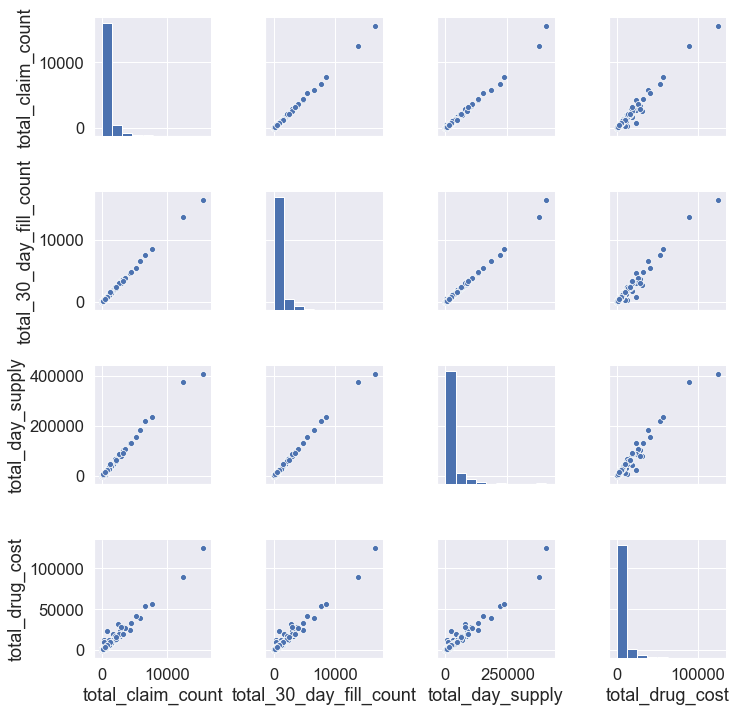

In [111]:
sns.pairplot(benzo_town_sum[benzo_town_sum['generic_name'] == 'alprazolam'])

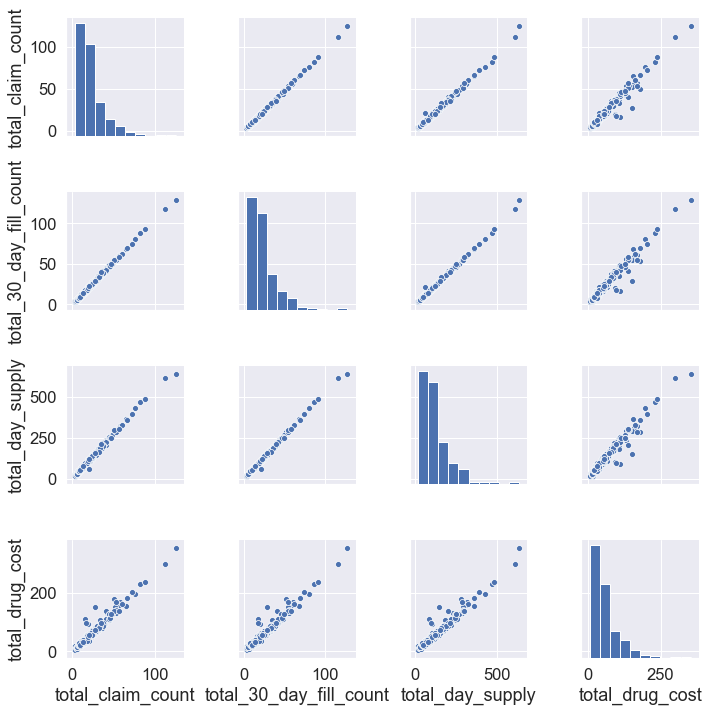

In [112]:
# skewed distribution - take square root
sns.pairplot(benzo_town_sum[benzo_town_sum['generic_name'] == 'alprazolam'].iloc[:, 2:].apply(np.sqrt))

In [113]:
benzo_town_sum_norm = benzo_town_sum.copy()
for x in list(benzo_town_sum_norm.columns)[2:]:
    benzo_town_sum_norm[x] = np.sqrt(benzo_town_sum_norm[x])
benzo_town_sum_norm.head()

,town,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
0,abington,alprazolam,16.583124,17.592612,91.564185,40.346127
1,abington,diazepam,9.055385,9.165151,43.680659,82.409283
2,abington,lorazepam,19.949937,21.000000,105.858396,54.652630
3,acton,alprazolam,15.329710,16.401219,80.187281,28.733604
4,acton,diazepam,13.453624,14.053469,70.978870,29.684845


All of the variable columns (claim count, total 30 day fill count, total supply, and total drug cost) seem to be highly correlated with each other. 

Is this true for all 3 drugs?

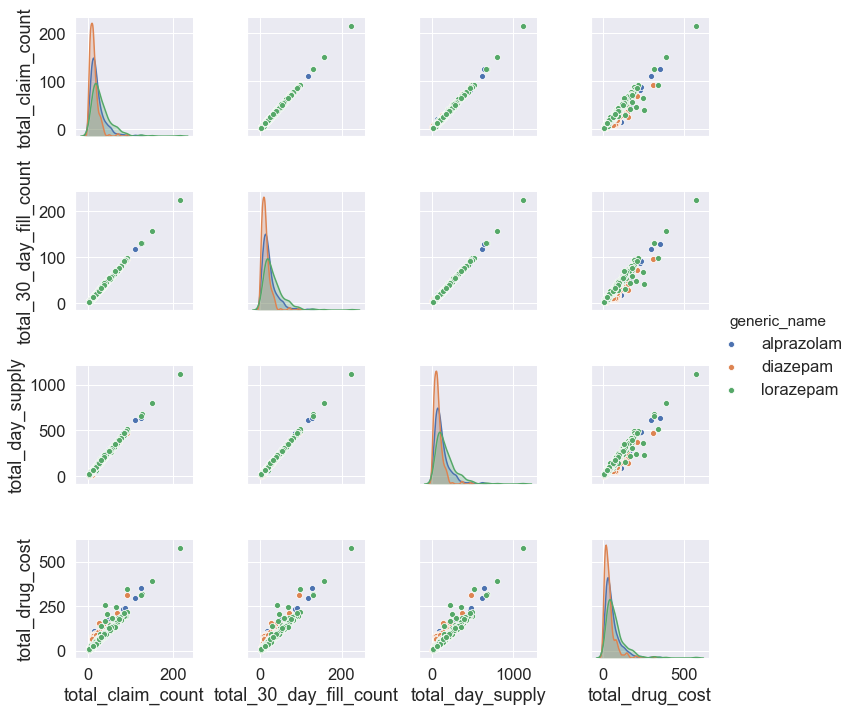

In [114]:
sns.pairplot(benzo_town_sum_norm, hue="generic_name")

Yes, all of the prescription data is highly skewed and all 4 features are very correlated with each other, for all 3 drugs.

## Clean older all-drug prescriber data

This is not the best way to do it, this was just a fast way to get throug these big datasets (2.7-3GB each). Basic strategy was to import each file one by one, pull out and clean the benzo prescriber data, and then remove the raw file from memory. 

In [115]:
del all_pres_17_raw

In [116]:
all_pres_16_raw =  pd.read_csv("../../data/raw_data/medicare_prescription_all_drugs/PartD_Prescriber_PUF_NPI_Drug_16.txt", sep='\t')

In [117]:
all_pres_16_raw.columns

Index(['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name',
       'nppes_provider_city', 'nppes_provider_state', 'specialty_description',
       'description_flag', 'drug_name', 'generic_name', 'bene_count',
       'total_claim_count', 'total_30_day_fill_count', 'total_day_supply',
       'total_drug_cost', 'bene_count_ge65', 'bene_count_ge65_suppress_flag',
       'total_claim_count_ge65', 'ge65_suppress_flag',
       'total_30_day_fill_count_ge65', 'total_day_supply_ge65',
       'total_drug_cost_ge65'],
      dtype='object')

In [118]:
all_pres_16_MA = all_pres_16_raw[all_pres_16_raw['nppes_provider_state'] == 'MA']
all_pres_16_MA.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_city,nppes_provider_state,specialty_description,description_flag,drug_name,generic_name,bene_count,...,total_30_day_fill_count,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
713,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,ACETAMINOPHEN-CODEINE,ACETAMINOPHEN WITH CODEINE,NaN,...,16.0,480,536.19,NaN,*,16.0,NaN,16.0,480.0,536.19
714,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,ADVAIR DISKUS,FLUTICASONE/SALMETEROL,NaN,...,39.0,1170,13618.31,NaN,*,13.0,NaN,39.0,1170.0,13618.31
715,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,ALLOPURINOL,ALLOPURINOL,14.0,...,90.8,2673,469.08,NaN,#,NaN,#,NaN,NaN,NaN
716,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,ALPRAZOLAM,ALPRAZOLAM,NaN,...,25.0,750,278.12,NaN,#,NaN,#,NaN,NaN,NaN
717,1003002312,HOPKINS,PATRICIA,QUINCY,MA,Rheumatology,S,AMLODIPINE BESYLATE,AMLODIPINE BESYLATE,14.0,...,125.0,3750,421.39,NaN,#,66.0,NaN,102.0,3060.0,384.86


In [119]:
alprazolam_16_pres = all_pres_16_MA[all_pres_16_MA['generic_name'].str.lower().str.find('alprazolam') >= 0]
print(alprazolam_16_pres.shape)
display(alprazolam_16_pres['drug_name'].value_counts())
diazepam_16_pres = all_pres_16_MA[all_pres_16_MA['generic_name'].str.lower().str.find('diazepam') >= 0]
print(diazepam_16_pres.shape)
display(diazepam_16_pres['drug_name'].value_counts())
lorazepam_16_pres = all_pres_16_MA[all_pres_16_MA['generic_name'].str.lower().str.find('lorazepam') >= 0]
print(lorazepam_16_pres.shape)
display(lorazepam_16_pres['drug_name'].value_counts())

(3921, 21)


ALPRAZOLAM             3866
XANAX                    26
ALPRAZOLAM ER            22
ALPRAZOLAM ODT            3
ALPRAZOLAM XR             2
ALPRAZOLAM INTENSOL       1
XANAX XR                  1
Name: drug_name, dtype: int64

(2583, 21)


DIAZEPAM    2567
VALIUM        16
Name: drug_name, dtype: int64

(6654, 21)


LORAZEPAM             6633
LORAZEPAM INTENSOL      11
ATIVAN                  10
Name: drug_name, dtype: int64

In [120]:
benzo_pres_16 = pd.concat([alprazolam_16_pres, diazepam_16_pres, lorazepam_16_pres]).drop(['nppes_provider_city', 'nppes_provider_state'], axis=1)
display(benzo_pres_16.head())
display(benzo_pres_16.info())

,npi,nppes_provider_last_org_name,nppes_provider_first_name,specialty_description,description_flag,drug_name,generic_name,bene_count,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,bene_count_ge65,bene_count_ge65_suppress_flag,total_claim_count_ge65,ge65_suppress_flag,total_30_day_fill_count_ge65,total_day_supply_ge65,total_drug_cost_ge65
716,1003002312,HOPKINS,PATRICIA,Rheumatology,S,ALPRAZOLAM,ALPRAZOLAM,NaN,21,25.0,750,278.12,NaN,#,NaN,#,NaN,NaN,NaN
2446,1003007477,ABDOW,KIMBERLY,Nurse Practitioner,S,ALPRAZOLAM,ALPRAZOLAM,NaN,26,30.0,876,253.86,NaN,*,NaN,*,NaN,NaN,NaN
4518,1003011610,RAY,ALAKA,Internal Medicine,S,ALPRAZOLAM,ALPRAZOLAM,NaN,14,25.0,633,34.17,NaN,*,14.0,NaN,25.0,633.0,34.17
8597,1003023284,MCELROY,ALLEGRA,Nurse Practitioner,S,ALPRAZOLAM,ALPRAZOLAM,NaN,13,13.0,370,21.10,NaN,*,NaN,*,NaN,NaN,NaN
15671,1003047473,HASSEY,SHERINE,Nurse Practitioner,S,ALPRAZOLAM,ALPRAZOLAM,11.0,16,22.0,656,76.62,NaN,#,NaN,#,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 13158 entries, 716 to 24960927
Data columns (total 19 columns):
npi                              13158 non-null int64
nppes_provider_last_org_name     13158 non-null object
nppes_provider_first_name        13158 non-null object
specialty_description            13158 non-null object
description_flag                 13158 non-null object
drug_name                        13158 non-null object
generic_name                     13158 non-null object
bene_count                       5613 non-null float64
total_claim_count                13158 non-null int64
total_30_day_fill_count          13158 non-null float64
total_day_supply                 13158 non-null int64
total_drug_cost                  13158 non-null float64
bene_count_ge65                  1826 non-null float64
bene_count_ge65_suppress_flag    11332 non-null object
total_claim_count_ge65           7275 non-null float64
ge65_suppress_flag               5883 non-null object
total_30

None

In [121]:
benzo_pres_16_sub = benzo_pres_16.dropna(axis=1).drop('description_flag', axis=1)
print(benzo_pres_16_sub.shape)
benzo_pres_16_sub.head()

(13158, 10)


,npi,nppes_provider_last_org_name,nppes_provider_first_name,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
716,1003002312,HOPKINS,PATRICIA,Rheumatology,ALPRAZOLAM,ALPRAZOLAM,21,25.0,750,278.12
2446,1003007477,ABDOW,KIMBERLY,Nurse Practitioner,ALPRAZOLAM,ALPRAZOLAM,26,30.0,876,253.86
4518,1003011610,RAY,ALAKA,Internal Medicine,ALPRAZOLAM,ALPRAZOLAM,14,25.0,633,34.17
8597,1003023284,MCELROY,ALLEGRA,Nurse Practitioner,ALPRAZOLAM,ALPRAZOLAM,13,13.0,370,21.10
15671,1003047473,HASSEY,SHERINE,Nurse Practitioner,ALPRAZOLAM,ALPRAZOLAM,16,22.0,656,76.62


In [122]:
for x in list(benzo_pres_16_sub.columns)[1:6]:
    benzo_pres_16_sub[x] = benzo_pres_16_sub[x].str.lower()

In [123]:
opi_pres_16_npi_town_match = med_opi_pres_no_town_dup[med_opi_pres_no_town_dup['year'] == 2016][['npi', 'nppes_provider_last_name', 'nppes_provider_first_name', 'town']].copy()
print(benzo_pres_16_sub.shape)
print(opi_pres_16_npi_town_match.shape)
benzo_town_merge_16 = benzo_pres_16_sub.merge(opi_pres_16_npi_town_match, how="inner", on="npi", suffixes=["_benz", "_opi"])
print(benzo_town_merge_16.shape)
print(benzo_town_merge_16.columns)
benzo_town_merge_16.head()

(13158, 10)
(34977, 4)
(13132, 13)
Index(['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name_benz',
       'specialty_description', 'drug_name', 'generic_name',
       'total_claim_count', 'total_30_day_fill_count', 'total_day_supply',
       'total_drug_cost', 'nppes_provider_last_name',
       'nppes_provider_first_name_opi', 'town'],
      dtype='object')


,npi,nppes_provider_last_org_name,nppes_provider_first_name_benz,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,nppes_provider_last_name,nppes_provider_first_name_opi,town
0,1003002312,hopkins,patricia,rheumatology,alprazolam,alprazolam,21,25.0,750,278.12,hopkins,patricia,quincy
1,1003002312,hopkins,patricia,rheumatology,diazepam,diazepam,19,19.0,507,89.89,hopkins,patricia,quincy
2,1003002312,hopkins,patricia,rheumatology,lorazepam,lorazepam,142,150.0,4380,782.41,hopkins,patricia,quincy
3,1003007477,abdow,kimberly,nurse practitioner,alprazolam,alprazolam,26,30.0,876,253.86,abdow,kimberly,worcester
4,1003007477,abdow,kimberly,nurse practitioner,diazepam,diazepam,25,25.0,750,121.84,abdow,kimberly,worcester


In [124]:
print(sum(benzo_town_merge_16['nppes_provider_last_org_name'] != benzo_town_merge_16['nppes_provider_last_name']))
print(sum(benzo_town_merge_16['nppes_provider_first_name_benz'] != benzo_town_merge_16['nppes_provider_first_name_opi']))
benzo_town_merge_16.drop(['nppes_provider_last_name', 'nppes_provider_first_name_opi'], axis=1, inplace=True)

0
0


In [125]:
print(benzo_town_merge_17.shape)
print(benzo_town_merge_16.shape)
display(benzo_town_merge_17.head())
display(benzo_town_merge_16.head())

(13138, 11)
(13132, 11)


,npi,nppes_provider_last_org_name,nppes_provider_first_name_benz,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,town
0,1003002312,hopkins,patricia,rheumatology,alprazolam,alprazolam,21,25.0,735,213.58,quincy
1,1003002312,hopkins,patricia,rheumatology,diazepam,diazepam,14,14.0,360,56.56,quincy
2,1003002312,hopkins,patricia,rheumatology,lorazepam,lorazepam,129,139.0,4028,907.84,quincy
3,1003007477,abdow,kimberly,nurse practitioner,alprazolam,alprazolam,63,75.0,2160,324.14,worcester
4,1003007477,abdow,kimberly,nurse practitioner,diazepam,diazepam,97,97.6,2920,781.21,worcester


,npi,nppes_provider_last_org_name,nppes_provider_first_name_benz,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,town
0,1003002312,hopkins,patricia,rheumatology,alprazolam,alprazolam,21,25.0,750,278.12,quincy
1,1003002312,hopkins,patricia,rheumatology,diazepam,diazepam,19,19.0,507,89.89,quincy
2,1003002312,hopkins,patricia,rheumatology,lorazepam,lorazepam,142,150.0,4380,782.41,quincy
3,1003007477,abdow,kimberly,nurse practitioner,alprazolam,alprazolam,26,30.0,876,253.86,worcester
4,1003007477,abdow,kimberly,nurse practitioner,diazepam,diazepam,25,25.0,750,121.84,worcester


2016 done - 2015 next

In [126]:
del all_pres_16_raw

In [127]:
all_pres_15_raw =  pd.read_csv("../../data/raw_data/medicare_prescription_all_drugs/PartD_Prescriber_PUF_NPI_Drug_15.txt", sep='\t')

In [128]:
all_pres_15_MA = all_pres_15_raw[all_pres_15_raw['nppes_provider_state'] == 'MA']
alprazolam_15_pres = all_pres_15_MA[all_pres_15_MA['generic_name'].str.lower().str.find('alprazolam') >= 0]
print(alprazolam_15_pres.shape)
display(alprazolam_15_pres['drug_name'].value_counts())
diazepam_15_pres = all_pres_15_MA[all_pres_15_MA['generic_name'].str.lower().str.find('diazepam') >= 0]
print(diazepam_15_pres.shape)
display(diazepam_15_pres['drug_name'].value_counts())
lorazepam_15_pres = all_pres_15_MA[all_pres_15_MA['generic_name'].str.lower().str.find('lorazepam') >= 0]
print(lorazepam_15_pres.shape)
display(lorazepam_15_pres['drug_name'].value_counts())

(3793, 21)


ALPRAZOLAM        3741
ALPRAZOLAM ER       24
XANAX               21
ALPRAZOLAM ODT       3
ALPRAZOLAM XR        2
XANAX XR             2
Name: drug_name, dtype: int64

(2588, 21)


DIAZEPAM    2575
VALIUM        13
Name: drug_name, dtype: int64

(6463, 21)


LORAZEPAM             6419
LORAZEPAM INTENSOL      31
ATIVAN                  13
Name: drug_name, dtype: int64

In [129]:
benzo_pres_15 = pd.concat([alprazolam_15_pres, diazepam_15_pres, lorazepam_15_pres]).drop(['nppes_provider_city', 'nppes_provider_state'], axis=1)
display(benzo_pres_15.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12844 entries, 652 to 24521569
Data columns (total 19 columns):
npi                              12844 non-null int64
nppes_provider_last_org_name     12844 non-null object
nppes_provider_first_name        12844 non-null object
specialty_description            12844 non-null object
description_flag                 12844 non-null object
drug_name                        12844 non-null object
generic_name                     12844 non-null object
bene_count                       5267 non-null float64
total_claim_count                12844 non-null int64
total_30_day_fill_count          12844 non-null float64
total_day_supply                 12844 non-null int64
total_drug_cost                  12844 non-null float64
bene_count_ge65                  1809 non-null float64
bene_count_ge65_suppress_flag    11035 non-null object
total_claim_count_ge65           7110 non-null float64
ge65_suppress_flag               5734 non-null object
total_30

None

In [130]:
benzo_pres_15_sub = benzo_pres_15.dropna(axis=1).drop('description_flag', axis=1)
print(benzo_pres_15_sub.shape)
benzo_pres_15_sub.head()

(12844, 10)


,npi,nppes_provider_last_org_name,nppes_provider_first_name,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
652,1003002312,HOPKINS,PATRICIA,Internal Medicine,ALPRAZOLAM,ALPRAZOLAM,26,32.0,960,263.50
14460,1003044272,BENDER,ELISE,Family Practice,ALPRAZOLAM,ALPRAZOLAM,15,19.0,439,51.41
19502,1003062647,BEAUZILE,RONALD,Internal Medicine,ALPRAZOLAM,ALPRAZOLAM,16,16.0,452,241.53
43176,1003164310,SIMPSON,SOMATRA,Nurse Practitioner,ALPRAZOLAM,ALPRAZOLAM,184,184.0,5450,1092.11
50083,1003218041,LYONS,PATRICK,Nurse Practitioner,ALPRAZOLAM,ALPRAZOLAM,16,16.0,418,60.67


In [131]:
for x in list(benzo_pres_15_sub.columns)[1:6]:
    benzo_pres_15_sub[x] = benzo_pres_15_sub[x].str.lower()

In [132]:
opi_pres_15_npi_town_match = med_opi_pres_no_town_dup[med_opi_pres_no_town_dup['year'] == 2015][['npi', 'nppes_provider_last_name', 'nppes_provider_first_name', 'town']].copy()
print(benzo_pres_15_sub.shape)
print(opi_pres_15_npi_town_match.shape)
benzo_town_merge_15 = benzo_pres_15_sub.merge(opi_pres_15_npi_town_match, how="inner", on="npi", suffixes=["_benz", "_opi"])
print(benzo_town_merge_15.shape)
print(benzo_town_merge_15.columns)
benzo_town_merge_15.head()

(12844, 10)
(34026, 4)
(12820, 13)
Index(['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name_benz',
       'specialty_description', 'drug_name', 'generic_name',
       'total_claim_count', 'total_30_day_fill_count', 'total_day_supply',
       'total_drug_cost', 'nppes_provider_last_name',
       'nppes_provider_first_name_opi', 'town'],
      dtype='object')


,npi,nppes_provider_last_org_name,nppes_provider_first_name_benz,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,nppes_provider_last_name,nppes_provider_first_name_opi,town
0,1003002312,hopkins,patricia,internal medicine,alprazolam,alprazolam,26,32.0,960,263.50,hopkins,patricia,quincy
1,1003002312,hopkins,patricia,internal medicine,diazepam,diazepam,17,17.0,501,65.54,hopkins,patricia,quincy
2,1003002312,hopkins,patricia,internal medicine,lorazepam,lorazepam,122,132.0,3773,707.43,hopkins,patricia,quincy
3,1003044272,bender,elise,family practice,alprazolam,alprazolam,15,19.0,439,51.41,bender,elise,braintree
4,1003044272,bender,elise,family practice,lorazepam,lorazepam,17,21.0,538,43.52,bender,elise,braintree


In [133]:
print(sum(benzo_town_merge_15['nppes_provider_last_org_name'] != benzo_town_merge_15['nppes_provider_last_name']))
print(sum(benzo_town_merge_15['nppes_provider_first_name_benz'] != benzo_town_merge_15['nppes_provider_first_name_opi']))
benzo_town_merge_15.drop(['nppes_provider_last_name', 'nppes_provider_first_name_opi'], axis=1, inplace=True)

0
0


In [134]:
print(benzo_town_merge_17.shape)
print(benzo_town_merge_16.shape)
print(benzo_town_merge_15.shape)

(13138, 11)
(13132, 11)
(12820, 11)


In [135]:
del all_pres_15_raw

In [136]:
all_pres_14_raw =  pd.read_csv("../../data/raw_data/medicare_prescription_all_drugs/PartD_Prescriber_PUF_NPI_Drug_14.txt", sep='\t')

In [137]:
all_pres_14_MA = all_pres_14_raw[all_pres_14_raw['nppes_provider_state'] == 'MA']
alprazolam_14_pres = all_pres_14_MA[all_pres_14_MA['generic_name'].str.lower().str.find('alprazolam') >= 0]
print(alprazolam_14_pres.shape)
display(alprazolam_14_pres['drug_name'].value_counts())
diazepam_14_pres = all_pres_14_MA[all_pres_14_MA['generic_name'].str.lower().str.find('diazepam') >= 0]
print(diazepam_14_pres.shape)
display(diazepam_14_pres['drug_name'].value_counts())
lorazepam_14_pres = all_pres_14_MA[all_pres_14_MA['generic_name'].str.lower().str.find('lorazepam') >= 0]
print(lorazepam_14_pres.shape)
display(lorazepam_14_pres['drug_name'].value_counts())

(3760, 21)


ALPRAZOLAM             3708
ALPRAZOLAM ER            24
XANAX                    19
ALPRAZOLAM XR             4
ALPRAZOLAM ODT            3
ALPRAZOLAM INTENSOL       1
XANAX XR                  1
Name: drug_name, dtype: int64

(2591, 21)


DIAZEPAM           2580
VALIUM               10
DIASTAT ACUDIAL       1
Name: drug_name, dtype: int64

(6293, 21)


LORAZEPAM             6274
ATIVAN                  10
LORAZEPAM INTENSOL       9
Name: drug_name, dtype: int64

In [138]:
benzo_pres_14 = pd.concat([alprazolam_14_pres, diazepam_14_pres, lorazepam_14_pres]).drop(['nppes_provider_city', 'nppes_provider_state'], axis=1)
display(benzo_pres_14.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12644 entries, 610 to 24117229
Data columns (total 19 columns):
npi                              12644 non-null int64
nppes_provider_last_org_name     12644 non-null object
nppes_provider_first_name        12644 non-null object
specialty_description            12644 non-null object
description_flag                 12644 non-null object
drug_name                        12644 non-null object
generic_name                     12644 non-null object
bene_count                       5009 non-null float64
total_claim_count                12644 non-null int64
total_30_day_fill_count          12644 non-null float64
total_day_supply                 12644 non-null int64
total_drug_cost                  12644 non-null float64
bene_count_ge65                  1746 non-null float64
bene_count_ge65_suppress_flag    10898 non-null object
total_claim_count_ge65           6850 non-null float64
ge65_suppress_flag               5794 non-null object
total_30

None

In [139]:
benzo_pres_14_sub = benzo_pres_14.dropna(axis=1).drop('description_flag', axis=1)
print(benzo_pres_14_sub.shape)
benzo_pres_14_sub.head()

(12644, 10)


,npi,nppes_provider_last_org_name,nppes_provider_first_name,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
610,1003002312,HOPKINS,PATRICIA,Internal Medicine,ALPRAZOLAM,ALPRAZOLAM,22,28.0,840,191.83
8082,1003023284,MCELROY,ALLEGRA,Nurse Practitioner,ALPRAZOLAM,ALPRAZOLAM,11,11.0,320,58.73
18800,1003062647,BEAUZILE,RONALD,Internal Medicine,ALPRAZOLAM,ALPRAZOLAM,16,16.0,448,116.43
25590,1003086976,KHERA,VANDANA,Internal Medicine,ALPRAZOLAM,ALPRAZOLAM,22,22.0,514,82.94
39132,1003164310,SIMPSON,SOMATRA,Nurse Practitioner,ALPRAZOLAM,ALPRAZOLAM,82,83.5,2348,462.21


In [140]:
for x in list(benzo_pres_14_sub.columns)[1:6]:
    benzo_pres_14_sub[x] = benzo_pres_14_sub[x].str.lower()

In [141]:
opi_pres_14_npi_town_match = med_opi_pres_no_town_dup[med_opi_pres_no_town_dup['year'] == 2014][['npi', 'nppes_provider_last_name', 'nppes_provider_first_name', 'town']].copy()
print(benzo_pres_14_sub.shape)
print(opi_pres_14_npi_town_match.shape)
benzo_town_merge_14 = benzo_pres_14_sub.merge(opi_pres_14_npi_town_match, how="inner", on="npi", suffixes=["_benz", "_opi"])
print(benzo_town_merge_14.shape)
print(benzo_town_merge_14.columns)
benzo_town_merge_14.head()

(12644, 10)
(33329, 4)
(12621, 13)
Index(['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name_benz',
       'specialty_description', 'drug_name', 'generic_name',
       'total_claim_count', 'total_30_day_fill_count', 'total_day_supply',
       'total_drug_cost', 'nppes_provider_last_name',
       'nppes_provider_first_name_opi', 'town'],
      dtype='object')


,npi,nppes_provider_last_org_name,nppes_provider_first_name_benz,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,nppes_provider_last_name,nppes_provider_first_name_opi,town
0,1003002312,hopkins,patricia,internal medicine,alprazolam,alprazolam,22,28.0,840,191.83,hopkins,patricia,quincy
1,1003002312,hopkins,patricia,internal medicine,diazepam,diazepam,26,26.0,755,166.64,hopkins,patricia,quincy
2,1003002312,hopkins,patricia,internal medicine,lorazepam,lorazepam,107,114.0,3393,676.93,hopkins,patricia,quincy
3,1003023284,mcelroy,allegra,nurse practitioner,alprazolam,alprazolam,11,11.0,320,58.73,mcelroy,allegra,mashpee
4,1003023284,mcelroy,allegra,nurse practitioner,diazepam,diazepam,17,17.0,481,55.05,mcelroy,allegra,mashpee


In [142]:
print(sum(benzo_town_merge_14['nppes_provider_last_org_name'] != benzo_town_merge_14['nppes_provider_last_name']))
print(sum(benzo_town_merge_14['nppes_provider_first_name_benz'] != benzo_town_merge_14['nppes_provider_first_name_opi']))
benzo_town_merge_14.drop(['nppes_provider_last_name', 'nppes_provider_first_name_opi'], axis=1, inplace=True)

0
0


In [143]:
print(benzo_town_merge_17.shape)
print(benzo_town_merge_16.shape)
print(benzo_town_merge_15.shape)
print(benzo_town_merge_14.shape)

(13138, 11)
(13132, 11)
(12820, 11)
(12621, 11)


2015 done - 2014 now

In [144]:
del all_pres_14_raw

In [145]:
all_pres_13_raw =  pd.read_csv("../../data/raw_data/medicare_prescription_all_drugs/PartD_Prescriber_PUF_NPI_Drug_13.txt", sep='\t')

In [146]:
all_pres_13_MA = all_pres_13_raw[all_pres_13_raw['nppes_provider_state'] == 'MA']
alprazolam_13_pres = all_pres_13_MA[all_pres_13_MA['generic_name'].str.lower().str.find('alprazolam') >= 0]
print(alprazolam_13_pres.shape)
display(alprazolam_13_pres['drug_name'].value_counts())
diazepam_13_pres = all_pres_13_MA[all_pres_13_MA['generic_name'].str.lower().str.find('diazepam') >= 0]
print(diazepam_13_pres.shape)
display(diazepam_13_pres['drug_name'].value_counts())
lorazepam_13_pres = all_pres_13_MA[all_pres_13_MA['generic_name'].str.lower().str.find('lorazepam') >= 0]
print(lorazepam_13_pres.shape)
display(lorazepam_13_pres['drug_name'].value_counts())

(3558, 21)


ALPRAZOLAM             3509
ALPRAZOLAM ER            26
XANAX                    14
ALPRAZOLAM XR             4
ALPRAZOLAM ODT            2
ALPRAZOLAM INTENSOL       2
XANAX XR                  1
Name: drug_name, dtype: int64

(2537, 21)


DIAZEPAM    2529
VALIUM         8
Name: drug_name, dtype: int64

(6088, 21)


LORAZEPAM             6069
LORAZEPAM INTENSOL      12
ATIVAN                   7
Name: drug_name, dtype: int64

In [147]:
benzo_pres_13 = pd.concat([alprazolam_13_pres, diazepam_13_pres, lorazepam_13_pres]).drop(['nppes_provider_city', 'nppes_provider_state'], axis=1)
display(benzo_pres_13.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12183 entries, 551 to 23642799
Data columns (total 19 columns):
npi                              12183 non-null int64
nppes_provider_last_org_name     12183 non-null object
nppes_provider_first_name        12183 non-null object
specialty_description            12183 non-null object
description_flag                 12183 non-null object
drug_name                        12183 non-null object
generic_name                     12183 non-null object
bene_count                       4763 non-null float64
total_claim_count                12183 non-null int64
total_30_day_fill_count          12183 non-null float64
total_day_supply                 12183 non-null int64
total_drug_cost                  12183 non-null float64
bene_count_ge65                  1696 non-null float64
bene_count_ge65_suppress_flag    10487 non-null object
total_claim_count_ge65           6628 non-null float64
ge65_suppress_flag               5555 non-null object
total_30

None

In [148]:
benzo_pres_13_sub = benzo_pres_13.dropna(axis=1).drop('description_flag', axis=1)
print(benzo_pres_13_sub.shape)
benzo_pres_13_sub.head()

(12183, 10)


,npi,nppes_provider_last_org_name,nppes_provider_first_name,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
551,1003002312,HOPKINS,PATRICIA,Internal Medicine,ALPRAZOLAM,ALPRAZOLAM,29,35.0,947,183.70
9410,1003030586,KSHEERSAGAR,PANKAJ,Family Practice,ALPRAZOLAM,ALPRAZOLAM,15,15.0,450,59.09
12142,1003042441,MANZO,MARK,Physician Assistant,ALPRAZOLAM,ALPRAZOLAM,17,17.0,500,77.42
17125,1003062647,BEAUZILE,RONALD,Internal Medicine,ALPRAZOLAM,ALPRAZOLAM,18,18.0,481,113.03
23373,1003086976,KHERA,VANDANA,Internal Medicine,ALPRAZOLAM,ALPRAZOLAM,17,17.0,495,72.85


In [149]:
for x in list(benzo_pres_13_sub.columns)[1:6]:
    benzo_pres_13_sub[x] = benzo_pres_13_sub[x].str.lower()

In [150]:
opi_pres_13_npi_town_match = med_opi_pres_no_town_dup[med_opi_pres_no_town_dup['year'] == 2013][['npi', 'nppes_provider_last_name', 'nppes_provider_first_name', 'town']].copy()
print(benzo_pres_13_sub.shape)
print(opi_pres_13_npi_town_match.shape)
benzo_town_merge_13 = benzo_pres_13_sub.merge(opi_pres_13_npi_town_match, how="inner", on="npi", suffixes=["_benz", "_opi"])
print(benzo_town_merge_13.shape)
print(benzo_town_merge_13.columns)
benzo_town_merge_13.head()

(12183, 10)
(32734, 4)
(12162, 13)
Index(['npi', 'nppes_provider_last_org_name', 'nppes_provider_first_name_benz',
       'specialty_description', 'drug_name', 'generic_name',
       'total_claim_count', 'total_30_day_fill_count', 'total_day_supply',
       'total_drug_cost', 'nppes_provider_last_name',
       'nppes_provider_first_name_opi', 'town'],
      dtype='object')


,npi,nppes_provider_last_org_name,nppes_provider_first_name_benz,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,nppes_provider_last_name,nppes_provider_first_name_opi,town
0,1003002312,hopkins,patricia,internal medicine,alprazolam,alprazolam,29,35.0,947,183.70,hopkins,patricia,quincy
1,1003002312,hopkins,patricia,internal medicine,diazepam,diazepam,16,16.0,460,86.53,hopkins,patricia,quincy
2,1003002312,hopkins,patricia,internal medicine,lorazepam,lorazepam,72,87.0,2496,510.97,hopkins,patricia,quincy
3,1003030586,ksheersagar,pankaj,family practice,alprazolam,alprazolam,15,15.0,450,59.09,ksheersagar,pankaj,worcester
4,1003042441,manzo,mark,physician assistant,alprazolam,alprazolam,17,17.0,500,77.42,manzo,mark,grafton


In [151]:
print(sum(benzo_town_merge_13['nppes_provider_last_org_name'] != benzo_town_merge_13['nppes_provider_last_name']))
print(sum(benzo_town_merge_13['nppes_provider_first_name_benz'] != benzo_town_merge_13['nppes_provider_first_name_opi']))
benzo_town_merge_13.drop(['nppes_provider_last_name', 'nppes_provider_first_name_opi'], axis=1, inplace=True)

0
0


In [152]:
print(benzo_town_merge_17.shape)
print(benzo_town_merge_16.shape)
print(benzo_town_merge_15.shape)
print(benzo_town_merge_14.shape)
print(benzo_town_merge_13.shape)

(13138, 11)
(13132, 11)
(12820, 11)
(12621, 11)
(12162, 11)


In [153]:
benzo_town_merge_17['year'] = 2017
benzo_town_merge_16['year'] = 2016
benzo_town_merge_15['year'] = 2015
benzo_town_merge_14['year'] = 2014
benzo_town_merge_13['year'] = 2013

In [154]:
benzo_pres_town_all = pd.concat([benzo_town_merge_17, benzo_town_merge_16, benzo_town_merge_15, benzo_town_merge_14, benzo_town_merge_13])
print(benzo_pres_town_all.shape)
display(benzo_pres_town_all.head())
sum(benzo_pres_town_all[['npi', 'year']].drop_duplicates()['npi'].value_counts() > 5)

(63873, 12)


,npi,nppes_provider_last_org_name,nppes_provider_first_name_benz,specialty_description,drug_name,generic_name,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost,town,year
0,1003002312,hopkins,patricia,rheumatology,alprazolam,alprazolam,21,25.0,735,213.58,quincy,2017
1,1003002312,hopkins,patricia,rheumatology,diazepam,diazepam,14,14.0,360,56.56,quincy,2017
2,1003002312,hopkins,patricia,rheumatology,lorazepam,lorazepam,129,139.0,4028,907.84,quincy,2017
3,1003007477,abdow,kimberly,nurse practitioner,alprazolam,alprazolam,63,75.0,2160,324.14,worcester,2017
4,1003007477,abdow,kimberly,nurse practitioner,diazepam,diazepam,97,97.6,2920,781.21,worcester,2017


0

In [155]:
#benzo_pres_town_all.to_csv("../../data/tidy_data/med_partD_benzo_indiv_pres_w_town_merge_13_to_17.csv", index=False)

In [156]:
benzo_town_year_sum = benzo_pres_town_all.groupby(['town', 'generic_name', 'year']).sum().reset_index().drop('npi', axis=1)
print(benzo_town_year_sum.shape)
benzo_town_year_sum.head()

(3653, 7)


,town,generic_name,year,total_claim_count,total_30_day_fill_count,total_day_supply,total_drug_cost
0,abington,alprazolam,2013,457,495.0,13567,3185.74
1,abington,alprazolam,2014,413,442.8,12428,2427.40
2,abington,alprazolam,2015,385,410.0,11241,2234.07
3,abington,alprazolam,2016,284,316.5,8777,1534.62
4,abington,alprazolam,2017,275,309.5,8384,1627.81


In [157]:
#benzo_town_year_sum.to_csv("../../data/tidy_data/med_partD_benzo_sum_w_town_merge_13_to_17.csv", index=False)